In [174]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [175]:
import numpy as np 
import pandas as pd
from   pandas import DataFrame

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# Statistics

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# Set the options
#pd.set_option('display.max_rows', 800)
#pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 100})
import warnings
warnings.filterwarnings("ignore")

In [176]:
# Input file name with path
input_file_name = '/content/sample_data/clean_data.csv'

# Target class name
input_target_variable = 'Heart_Rate'

# Date column name
input_date_variable = 'Timestamp'

#Exogenous variable
input_exogenous_variable = 'Oximeter SpO2'

# Handle missing value
input_treat_missing_value = 'bfill' # choose how to handle missing values from 'ffill','bfill' 

# Box-cox transformation flag
input_transform_flag = 'Yes' # choose if you wish to transform the data - 'Yes' or 'No'

# Seasonality
input_seasonality = 12
input_order = (0, 1 , 2)
input_seasonal_order = (2, 1, 0, input_seasonality)

# Forecasting algorithm
 # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'
input_ts_algo = 'auto_arima'


In [177]:
# Read data in form of a csv file
df = pd.read_csv(input_file_name)

df[input_date_variable] = pd.to_datetime(df[input_date_variable])
df['Heart_Rate'] = df['Heart_Rate'].astype(float)

# First 5 rows of the dataset
df.head()

,Timestamp,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139.0,41,92,140
1,2015-08-17 15:10:00,144.0,40,92,140
2,2015-08-17 15:11:00,140.0,42,89,144
3,2015-08-17 15:12:00,138.0,45,93,141
4,2015-08-17 15:13:00,133.0,42,94,134


In [178]:
# Dimension of the data
df.shape


(226, 5)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Timestamp                   226 non-null    datetime64[ns]
 1   Heart_Rate                  226 non-null    float64       
 2   Lifetouch Respiration Rate  226 non-null    int64         
 3   Oximeter SpO2               226 non-null    int64         
 4   Oximeter Pulse              226 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 9.0 KB


In [180]:
# Summary of the dataset
df.describe()

,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,226.000000,226.000000
mean,145.163717,45.769912,73.367257,111.495575
std,11.801496,7.789462,39.245581,60.339134
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,133.000000
50%,142.000000,45.000000,93.000000,137.000000
75%,155.000000,52.000000,95.000000,148.000000
max,172.000000,64.000000,98.000000,166.000000


In [181]:
# Missing values for every column
df.isna().sum()

Timestamp                     0
Heart_Rate                    0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [182]:
# Select how you wish to treat missing values according to the input
df = df.ffill()
df = df.bfill()

In [183]:
df.isna().sum()

Timestamp                     0
Heart_Rate                    0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [184]:
df.head()

,Timestamp,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139.0,41,92,140
1,2015-08-17 15:10:00,144.0,40,92,140
2,2015-08-17 15:11:00,140.0,42,89,144
3,2015-08-17 15:12:00,138.0,45,93,141
4,2015-08-17 15:13:00,133.0,42,94,134


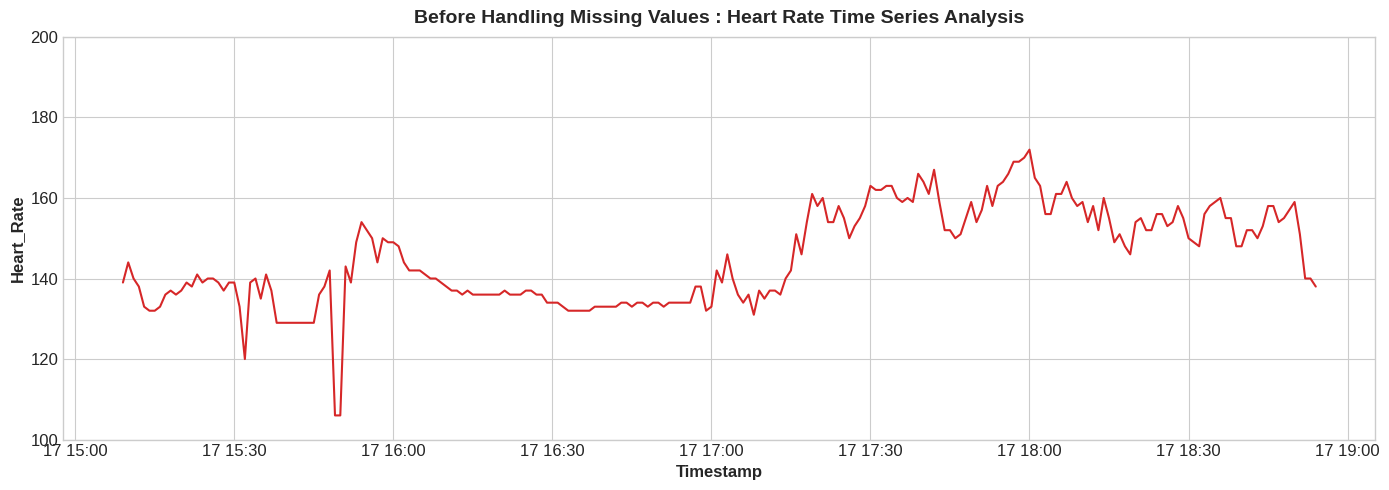

In [185]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Timestamp', ylabel='Heart_Rate', dpi=100):
    plt.figure(figsize=(14,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.ylim(100, 200)

plot_df(x=df[input_date_variable], y=df[input_target_variable], title='Before Handling Missing Values : Heart Rate Time Series Analysis')

In [186]:
df = df.replace({'Heart_Rate':{61441:np.nan, 61442:np.nan}, 'Lifetouch Respiration Rate':{61441:np.nan, 61442:np.nan}})

In [187]:
df.isnull().sum()

Timestamp                     0
Heart_Rate                    0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [188]:
df = df.ffill()

In [189]:
df.isnull().sum()

Timestamp                     0
Heart_Rate                    0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [190]:
df.to_csv('data.csv')

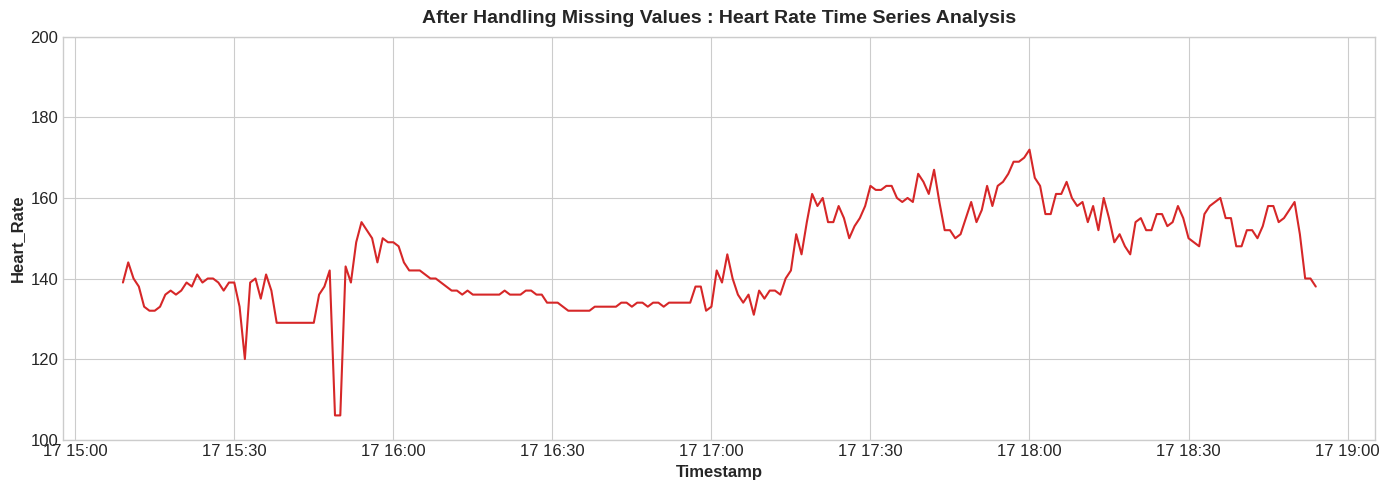

In [191]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Timestamp', ylabel='Heart_Rate', dpi=100):
    plt.figure(figsize=(14,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.ylim(100, 200)

plot_df(x=df[input_date_variable], y=df[input_target_variable], title='After Handling Missing Values : Heart Rate Time Series Analysis')

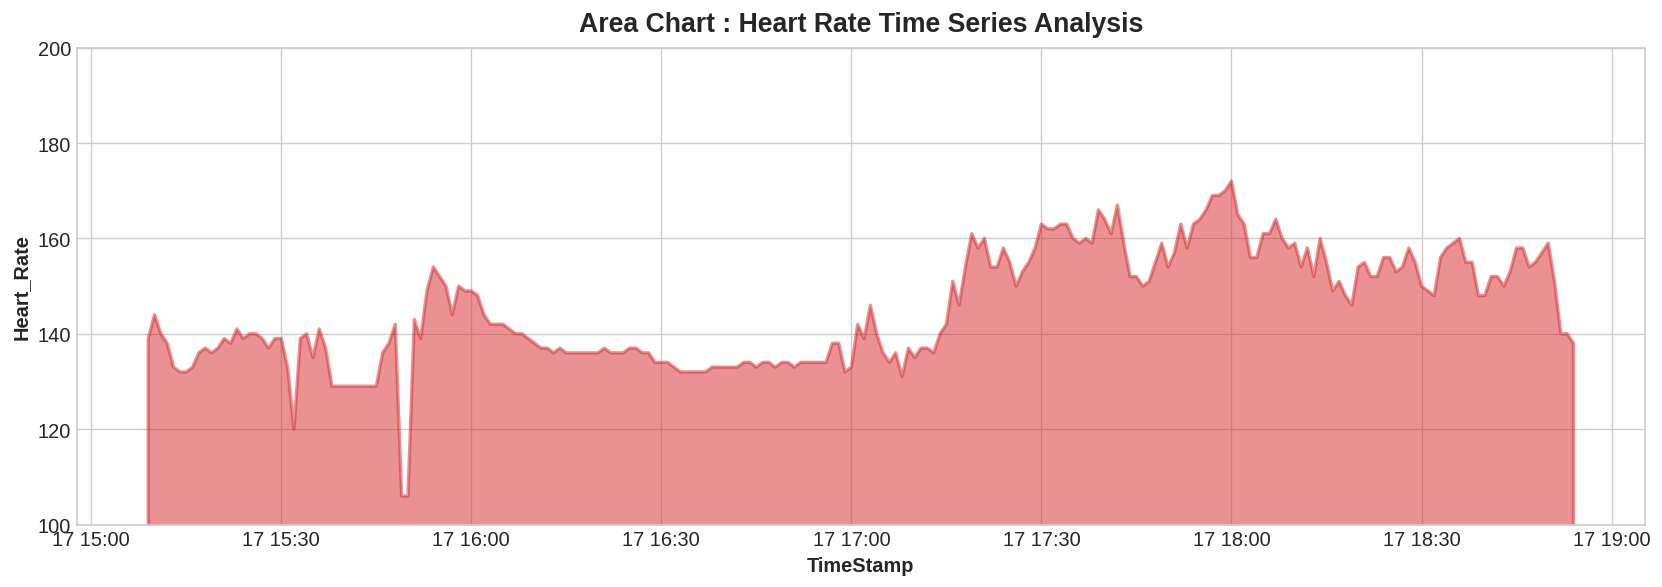

In [192]:
# Draw plot
x = df[input_date_variable]
y1 = df[input_target_variable].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14,5), dpi= 120)
plt.fill_between(x, y1=y1, alpha=0.5, linewidth=2, color='tab:red')
plt.title('Area Chart : Heart Rate Time Series Analysis', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.Timestamp), xmax=np.max(df.Timestamp), linewidth=.5)
plt.xlabel('TimeStamp')
plt.ylabel('Heart_Rate')
plt.ylim(100, 200)
plt.show()

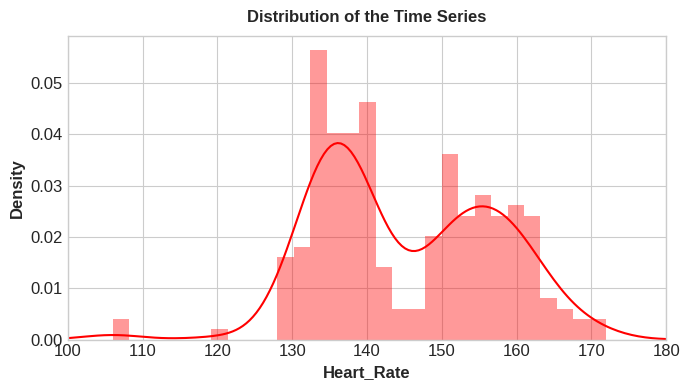

In [193]:
plt.figure(figsize = (7,4))
sns.distplot(df[input_target_variable], kde = True, color ='red', bins = 30)
plt.title('Distribution of the Time Series', fontsize=12)
plt.xlim(100,180)
plt.show()

In [194]:
import scipy.stats as ss
import pylab

In [195]:
print(df[input_target_variable].shape)

(226,)


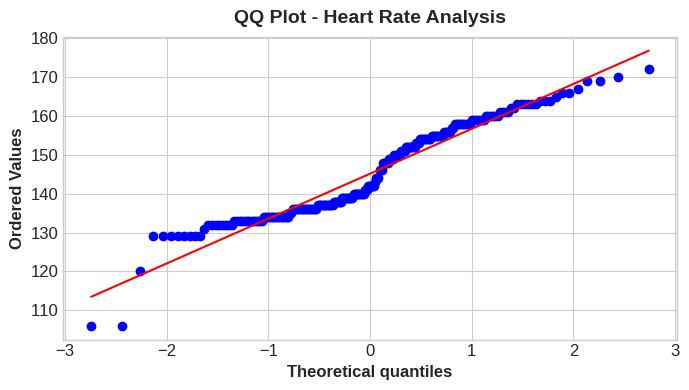

In [196]:
pylab.figure(figsize=(7,4))
ss.probplot(df.Heart_Rate,plot = pylab)
pylab.title('QQ Plot - Heart Rate Analysis')
pylab.show()

Text(0.5, 0.98, 'Multiplicative Decompose')

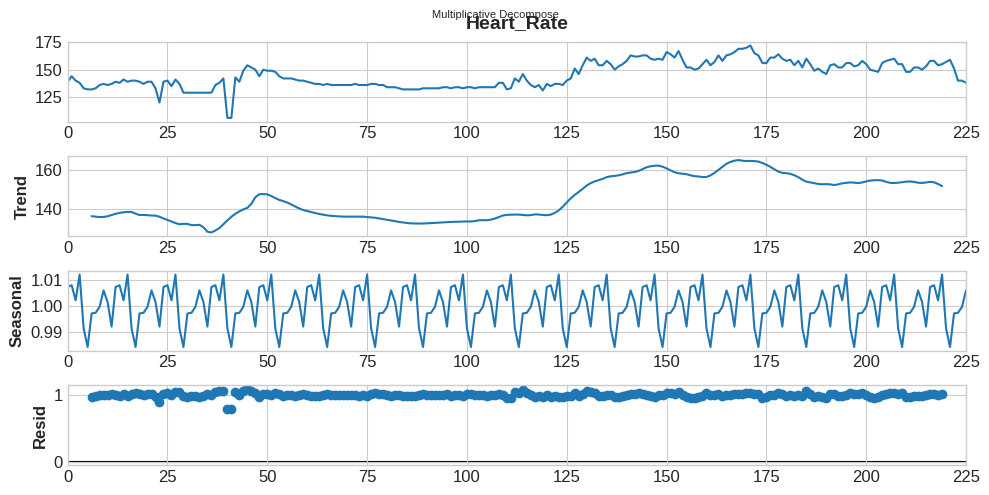

In [197]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df[input_target_variable], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target_variable], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=8)

Text(0.5, 0.98, 'Multiplicative Decompose')

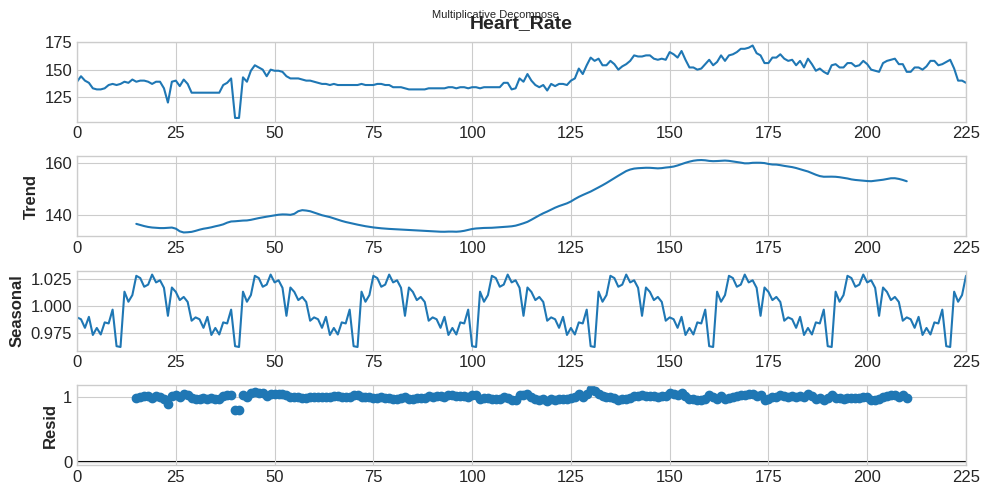

In [198]:
#####
result_mul = seasonal_decompose(df[input_target_variable], model='multiplicative', period=30)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target_variable], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=8)

Text(0.5, 0.98, 'Additive Decompose')

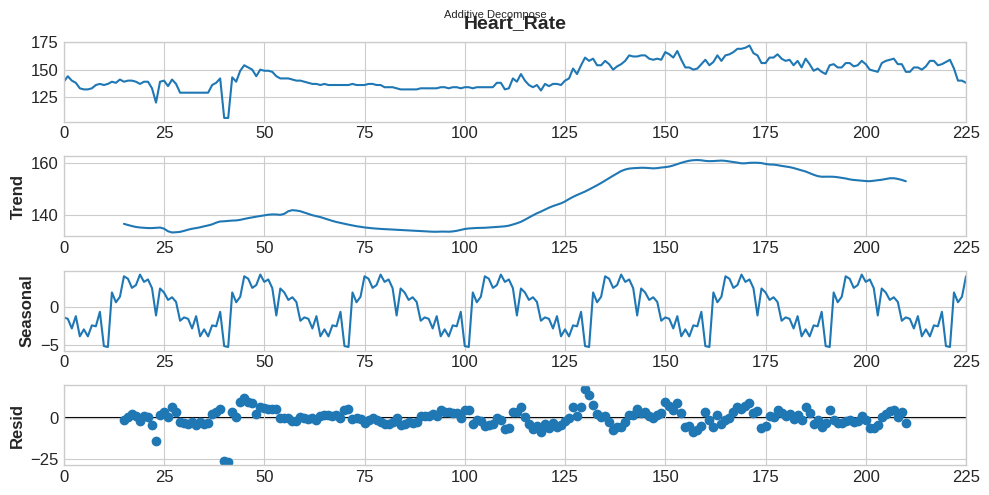

In [199]:
result_add.plot().suptitle('Additive Decompose', fontsize=8)

In [200]:
# ADF Test
result = adfuller(df[input_target_variable].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0062983264332157
p-value: 0.28381834919001564
Critial Values:
   1%, -3.4602906385073884
Critial Values:
   5%, -2.874708679520702
Critial Values:
   10%, -2.573788599127782


In [201]:
# check stationarity of the series
import statsmodels.api as sm

def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [202]:
check_stationarity(df['Heart_Rate'])

p value: 0.01
Result: The series is not stationary 



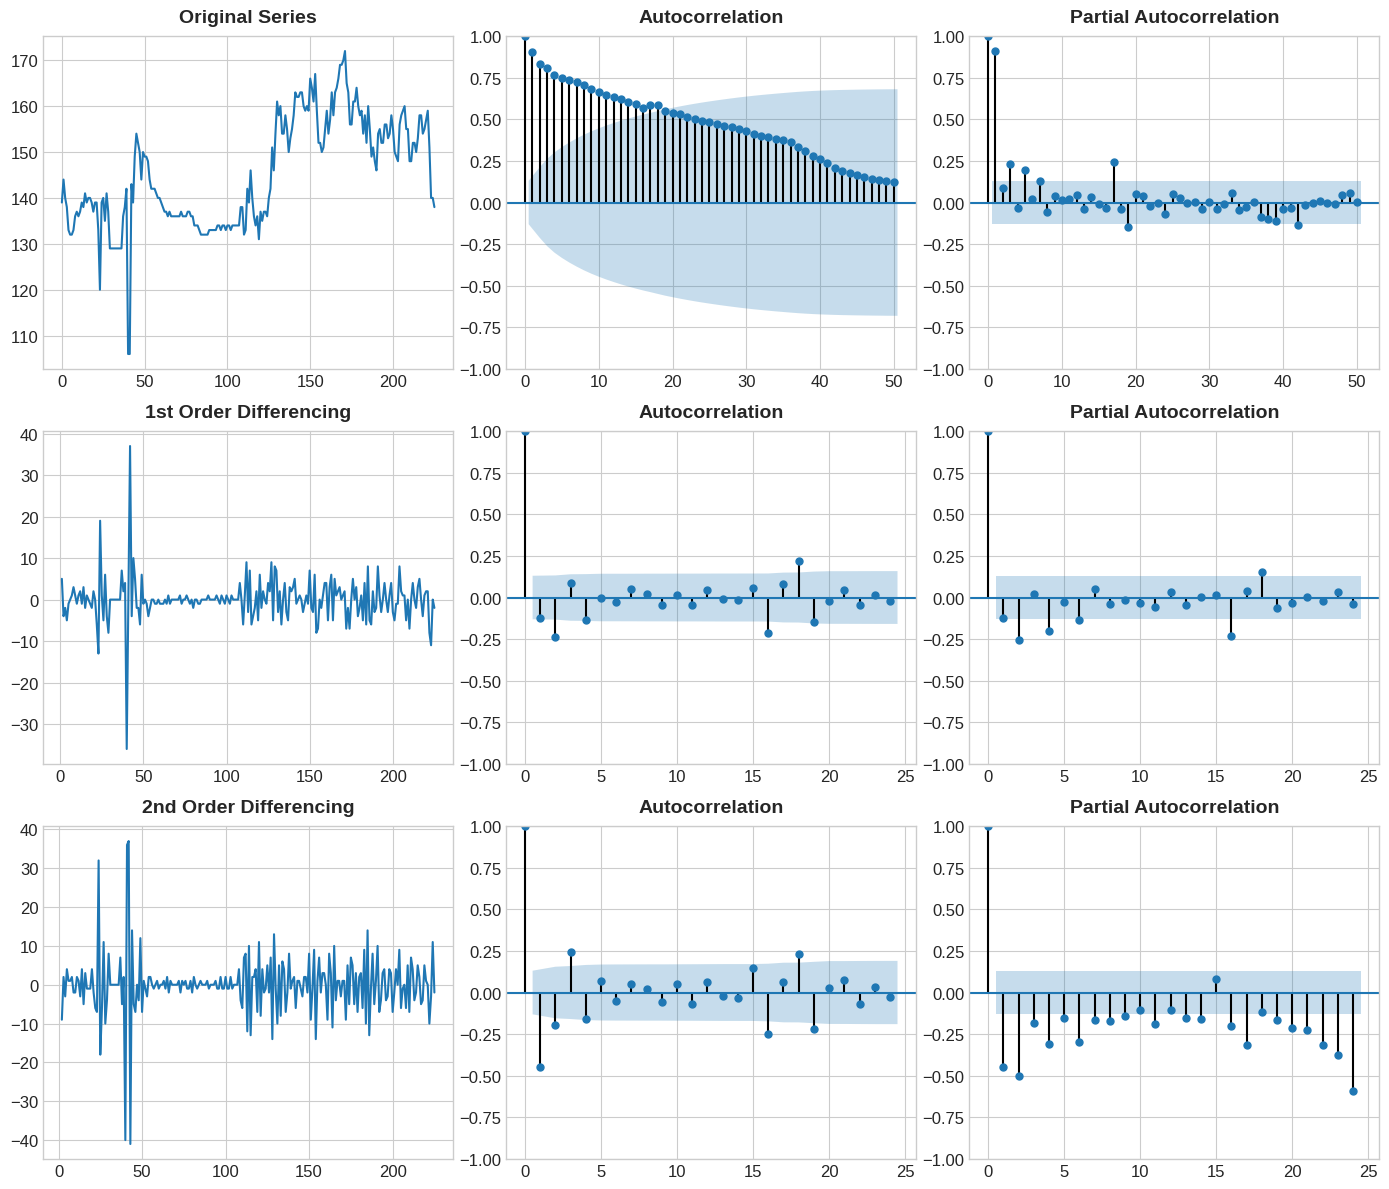

In [203]:
# Original Series

fig, axes = plt.subplots(3, 3, figsize=(14,12), dpi= 100)
axes[0, 0].plot(df[input_target_variable]);
axes[0, 0].set_title('Original Series')
plot_acf(df[input_target_variable],lags=50, ax=axes[0, 1])
plot_pacf(df[input_target_variable], lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(df[input_target_variable].diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df[input_target_variable].diff().dropna(), ax=axes[1, 1])
plot_pacf(df[input_target_variable].diff().dropna(), ax=axes[1, 2])


# 2nd Differencing
axes[2, 0].plot(df[input_target_variable].diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df[input_target_variable].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df[input_target_variable].diff().diff().dropna(), ax=axes[2, 2])

plt.show();

In [204]:
# ADF Test for 1 order of differencing
result = adfuller(df[input_target_variable].diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.370466584275603
p-value: 2.67086003824761e-13
Critial Values:
   1%, -3.460567372610299
Critial Values:
   5%, -2.874829809033386
Critial Values:
   10%, -2.573853225954421


In [205]:
# ADF Test for 2 order of differencing
result = adfuller(df[input_target_variable].diff().diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.9324288311508155
p-value: 2.3633341725558015e-07
Critial Values:
   1%, -3.4621857592784546
Critial Values:
   5%, -2.875537986778846
Critial Values:
   10%, -2.574231080806213


In [206]:
df.head()

,Timestamp,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139.0,41,92,140
1,2015-08-17 15:10:00,144.0,40,92,140
2,2015-08-17 15:11:00,140.0,42,89,144
3,2015-08-17 15:12:00,138.0,45,93,141
4,2015-08-17 15:13:00,133.0,42,94,134


In [207]:
train_pct = 0.80
train_size = int(len(df) * train_pct)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:]

In [208]:
print('Train Data :',train.shape)
print('Test Data :',test.shape)

Train Data : (180, 5)
Test Data : (46, 5)


In [209]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target_variable], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = True, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

In [210]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

In [211]:
def model_holt_winters(y, seasonality):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend='add', seasonal='add',).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

In [212]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

In [213]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [214]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [215]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))

    
    analyse_error(actuals, predictions)
  
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

------------- Auto ARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1098.136, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1110.876, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1111.430, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1108.083, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1108.963, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1096.204, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1098.139, Time=0.34 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1100.146, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1106.166, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1109.600, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1095.869, Time=0.20 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1097.866, Time=0.57 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1097.866, Time=0.56 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=

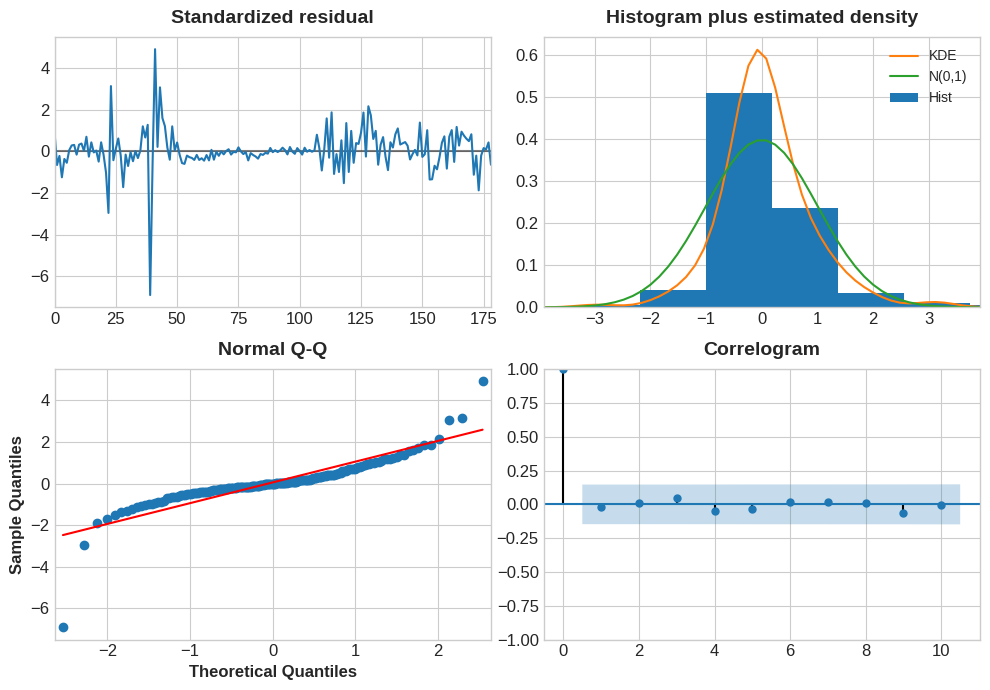

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  5.426443327368852
MAE  :  8.114553914358714
RMSE  :  9.604260688575591
R2 Score  :  -2.530053140773253


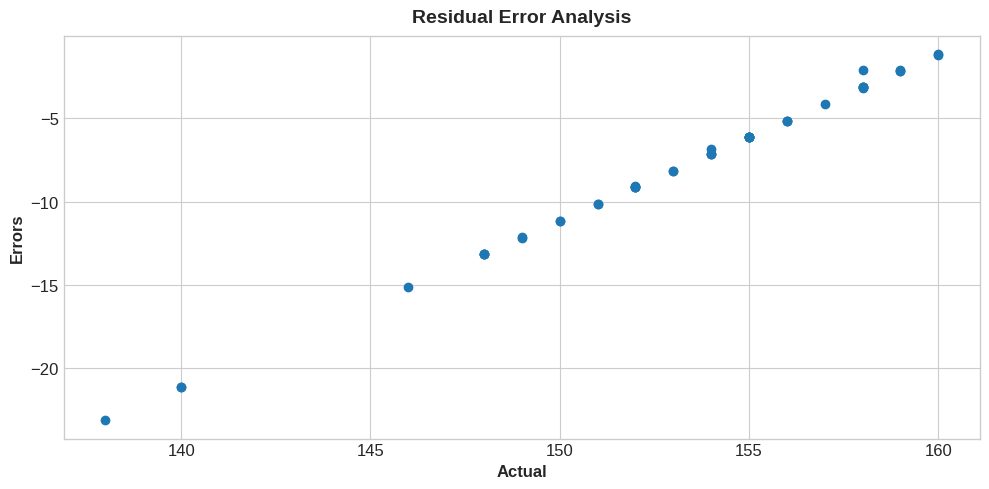

0     160.070764
1     161.090063
2     160.864296
3     161.198236
4     161.055973
5     161.181806
6     161.112510
7     161.163700
8     161.132376
9     161.153954
10    161.140170
11    161.149405
12    161.143403
13    161.147380
14    161.144777
15    161.146494
16    161.145367
17    161.146109
18    161.145621
19    161.145942
dtype: float64


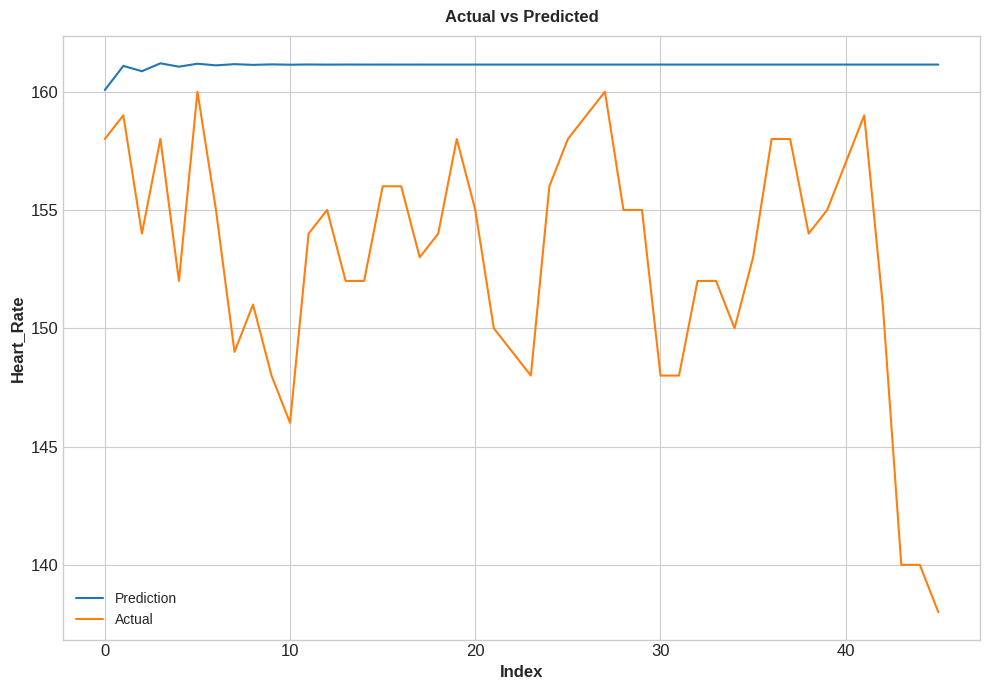

In [216]:
# Get actual values
actuals = test[input_target_variable].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)


elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target_variable])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)

In [217]:
input_ts_algo = 'simple_exponential_smoothing'

In [218]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=True)
    
    # Model summary 
    print(model.summary())
    
    return model

In [219]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

In [220]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [221]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [222]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))

    
    analyse_error(actuals, predictions)
  
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

------------- Simple Exponential Smoothing --------------- 

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  180
Model:             SimpleExpSmoothing   SSE                           4944.714
Optimized:                       True   AIC                            600.361
Trend:                           None   BIC                            606.747
Seasonal:                        None   AICC                           600.590
Seasonal Periods:                None   Date:                 Sat, 10 Dec 2022
Box-Cox:                        False   Time:                         05:55:55
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6000000                alpha             

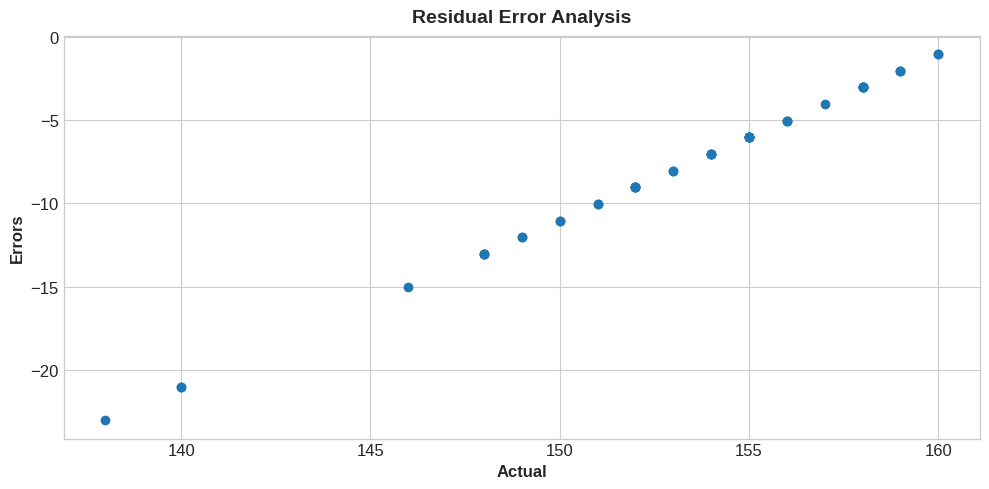

0     161.027836
1     161.027836
2     161.027836
3     161.027836
4     161.027836
5     161.027836
6     161.027836
7     161.027836
8     161.027836
9     161.027836
10    161.027836
11    161.027836
12    161.027836
13    161.027836
14    161.027836
15    161.027836
16    161.027836
17    161.027836
18    161.027836
19    161.027836
dtype: float64


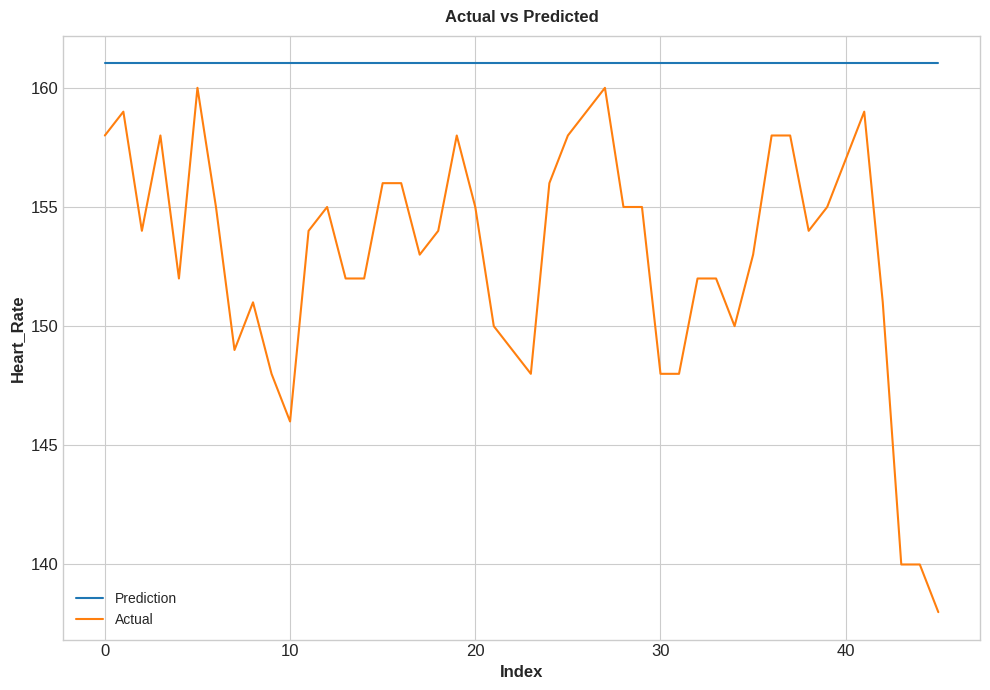

In [223]:
# Get actual values
actuals = test[input_target_variable].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)


elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target_variable])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)

In [224]:
input_ts_algo = 'holt_winters'

In [225]:
def model_holt_winters(y, seasonality):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend='add', seasonal='add',).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

In [226]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

In [227]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [229]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))

    
    analyse_error(actuals, predictions)
  
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

------------- Holt Winters --------------- 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  180
Model:             ExponentialSmoothing   SSE                           4439.305
Optimized:                         True   AIC                            608.953
Trend:                         Additive   BIC                            660.041
Seasonal:                      Additive   AICC                           613.202
Seasonal Periods:                    12   Date:                 Sat, 10 Dec 2022
Box-Cox:                          False   Time:                         05:55:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7506182                alpha  

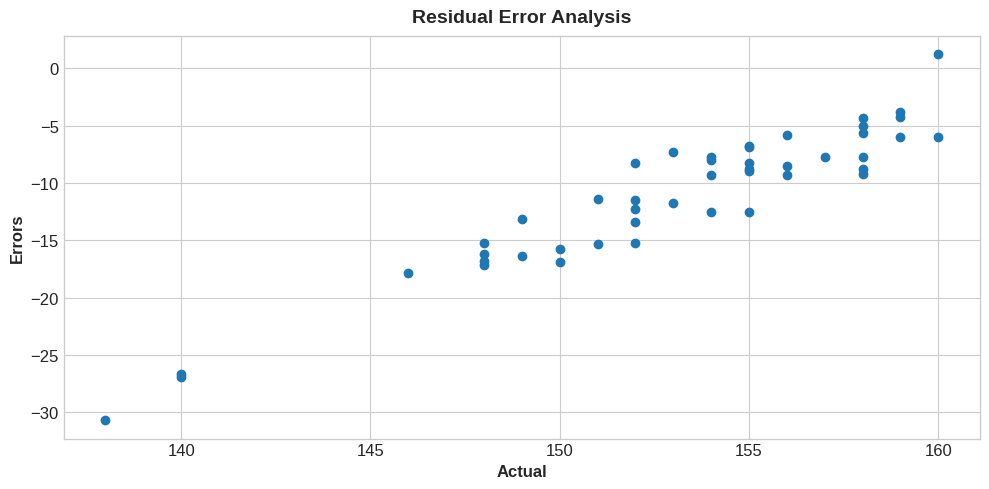

0     162.299326
1     162.765676
2     162.031476
3     163.031964
4     160.297627
5     158.764145
6     161.831342
7     162.164435
8     162.430664
9     164.230833
10    163.897699
11    161.764384
12    163.793045
13    164.259395
14    163.525195
15    164.525683
16    161.791346
17    160.257864
18    163.325061
19    163.658154
dtype: float64


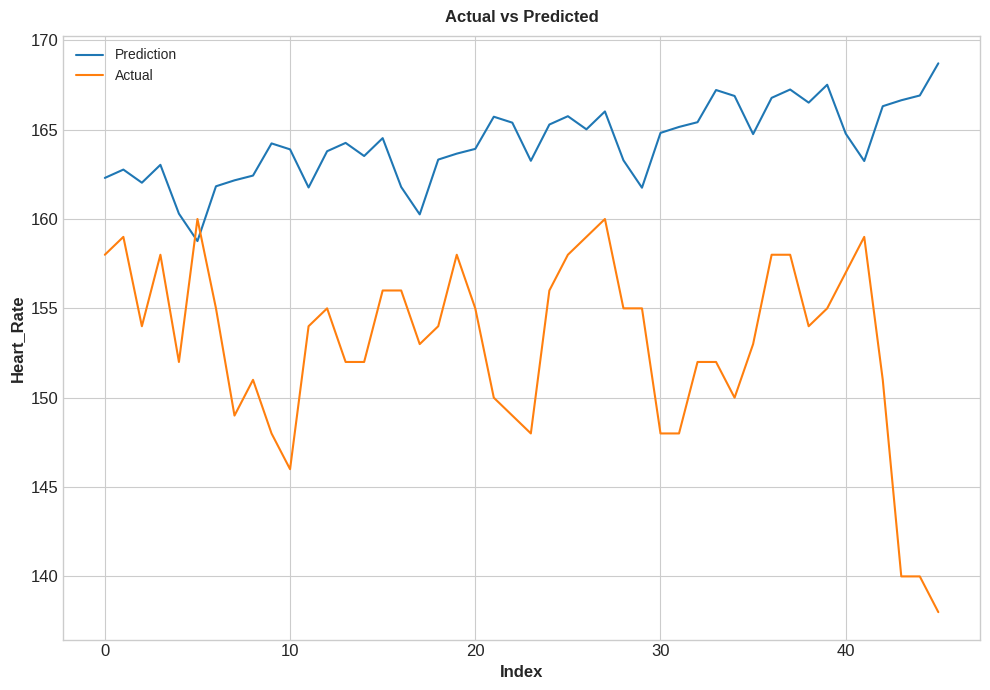

In [230]:
# Get actual values
actuals = test[input_target_variable].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)


elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target_variable])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    print(predictions[:20])



# ARIMA

In [231]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
#plt.style.use('')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [233]:
df = pd.read_csv('/content/sample_data/clean_data.csv')
df.head()

,Timestamp,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,92,140
1,17/08/2015 15:10,144,40,92,140
2,17/08/2015 15:11,140,42,89,144
3,17/08/2015 15:12,138,45,93,141
4,17/08/2015 15:13,133,42,94,134


In [234]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Timestamp                   226 non-null    datetime64[ns]
 1   Heart_Rate                  226 non-null    int64         
 2   Lifetouch Respiration Rate  226 non-null    int64         
 3   Oximeter SpO2               226 non-null    int64         
 4   Oximeter Pulse              226 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 9.0 KB


In [236]:
cols = ['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse']
df.drop(cols,axis=1, inplace=True)
df.head()

,Timestamp,Heart_Rate
0,2015-08-17 15:09:00,139
1,2015-08-17 15:10:00,144
2,2015-08-17 15:11:00,140
3,2015-08-17 15:12:00,138
4,2015-08-17 15:13:00,133


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Timestamp   226 non-null    datetime64[ns]
 1   Heart_Rate  226 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.7 KB


In [238]:
df = df.set_index('Timestamp')
df.index

DatetimeIndex(['2015-08-17 15:09:00', '2015-08-17 15:10:00',
               '2015-08-17 15:11:00', '2015-08-17 15:12:00',
               '2015-08-17 15:13:00', '2015-08-17 15:14:00',
               '2015-08-17 15:15:00', '2015-08-17 15:16:00',
               '2015-08-17 15:17:00', '2015-08-17 15:18:00',
               ...
               '2015-08-17 18:45:00', '2015-08-17 18:46:00',
               '2015-08-17 18:47:00', '2015-08-17 18:48:00',
               '2015-08-17 18:49:00', '2015-08-17 18:50:00',
               '2015-08-17 18:51:00', '2015-08-17 18:52:00',
               '2015-08-17 18:53:00', '2015-08-17 18:54:00'],
              dtype='datetime64[ns]', name='Timestamp', length=226, freq=None)

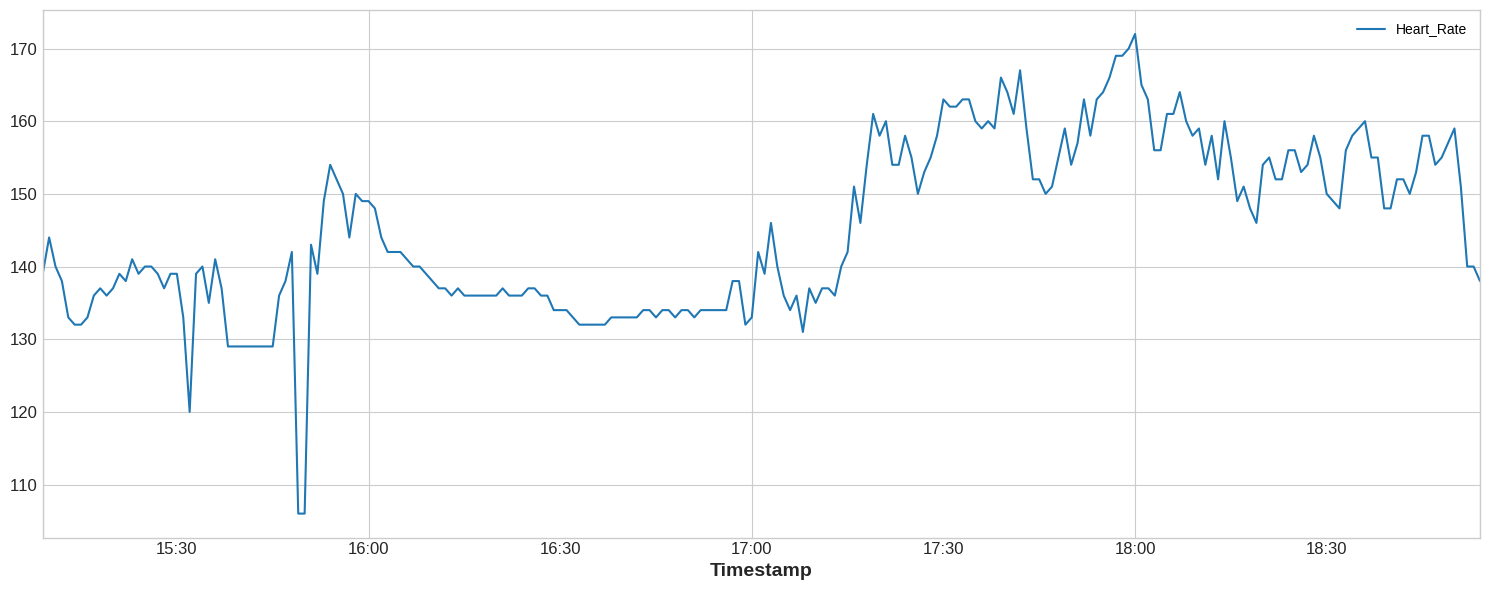

In [239]:
df.plot(figsize=(15, 6))
plt.show()

In [240]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [241]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2882.1251069896543
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2486.1571670187914
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1581.138829786437
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1476.6600352195044
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1589.020389294922
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1557.1025816248593
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1486.5136372632537
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1480.9732424490617
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2569.4704637944237
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2195.499330267697
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1448.2212131752156
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1330.9017915552713
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1462.923502130573
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1407.4671227480899
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1353.4125250258871
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1341.2409592923052
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1368.3426470905333
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1306.0632627730

In [242]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6329      0.138      4.579      0.000       0.362       0.904
ma.L1         -0.8565      0.105     -8.129      0.000      -1.063      -0.650
ma.S.L12      -1.0980      0.104    -10.603      0.000      -1.301      -0.895
sigma2        21.1788      2.805      7.550      0.000      15.681      26.677


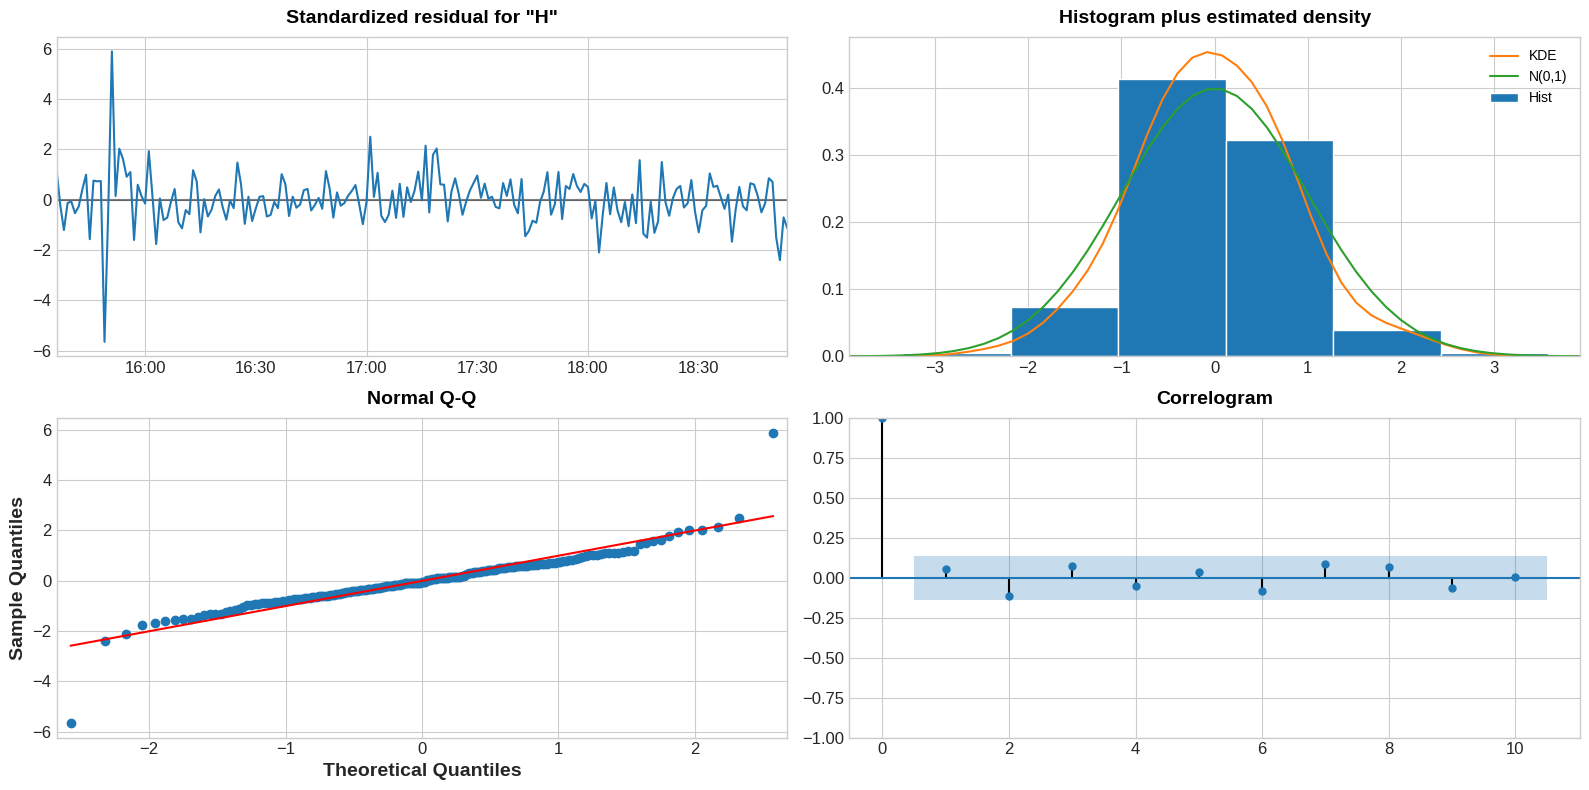

In [243]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

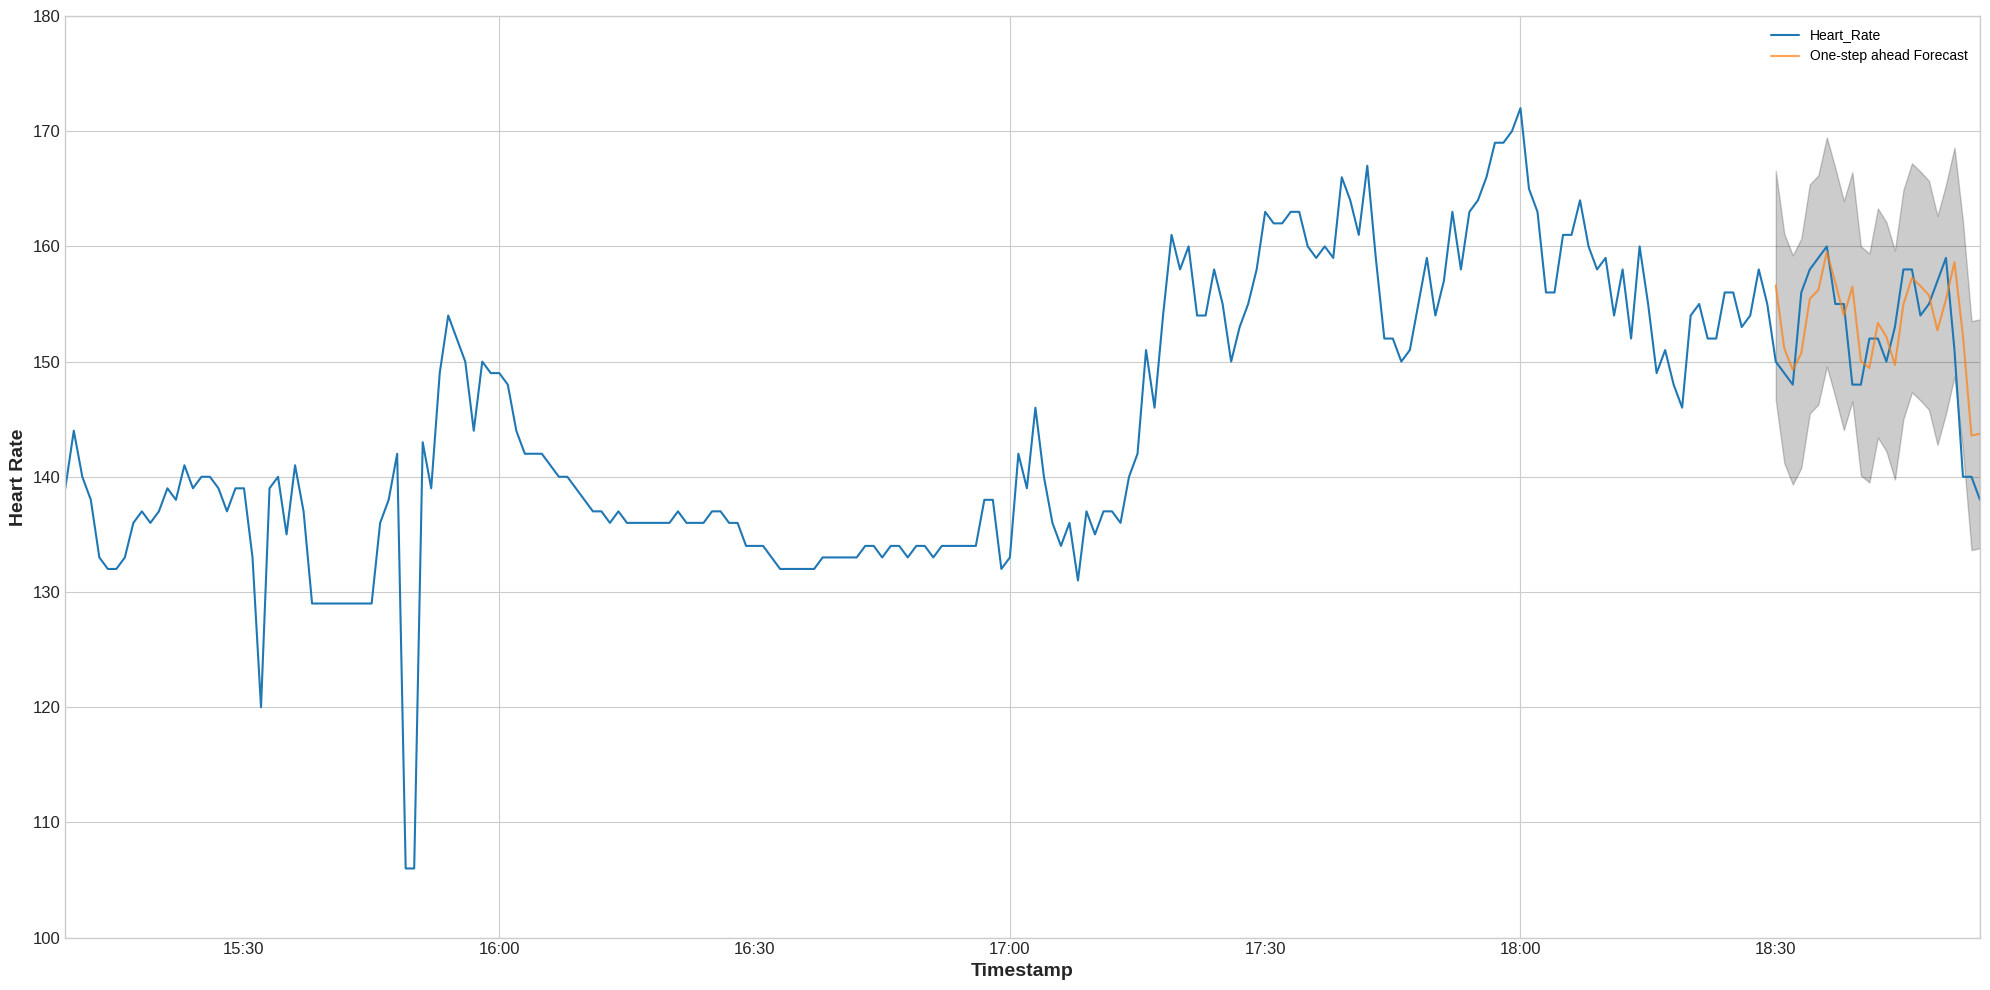

In [244]:
pred = results.get_prediction(start=pd.to_datetime('2015-08-17 18:30:00'), dynamic=False)
pred_ci = pred.conf_int()

ax = df['2015-08-17 14:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 10))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Heart Rate')
plt.legend()
plt.ylim(100,180)
plt.show()

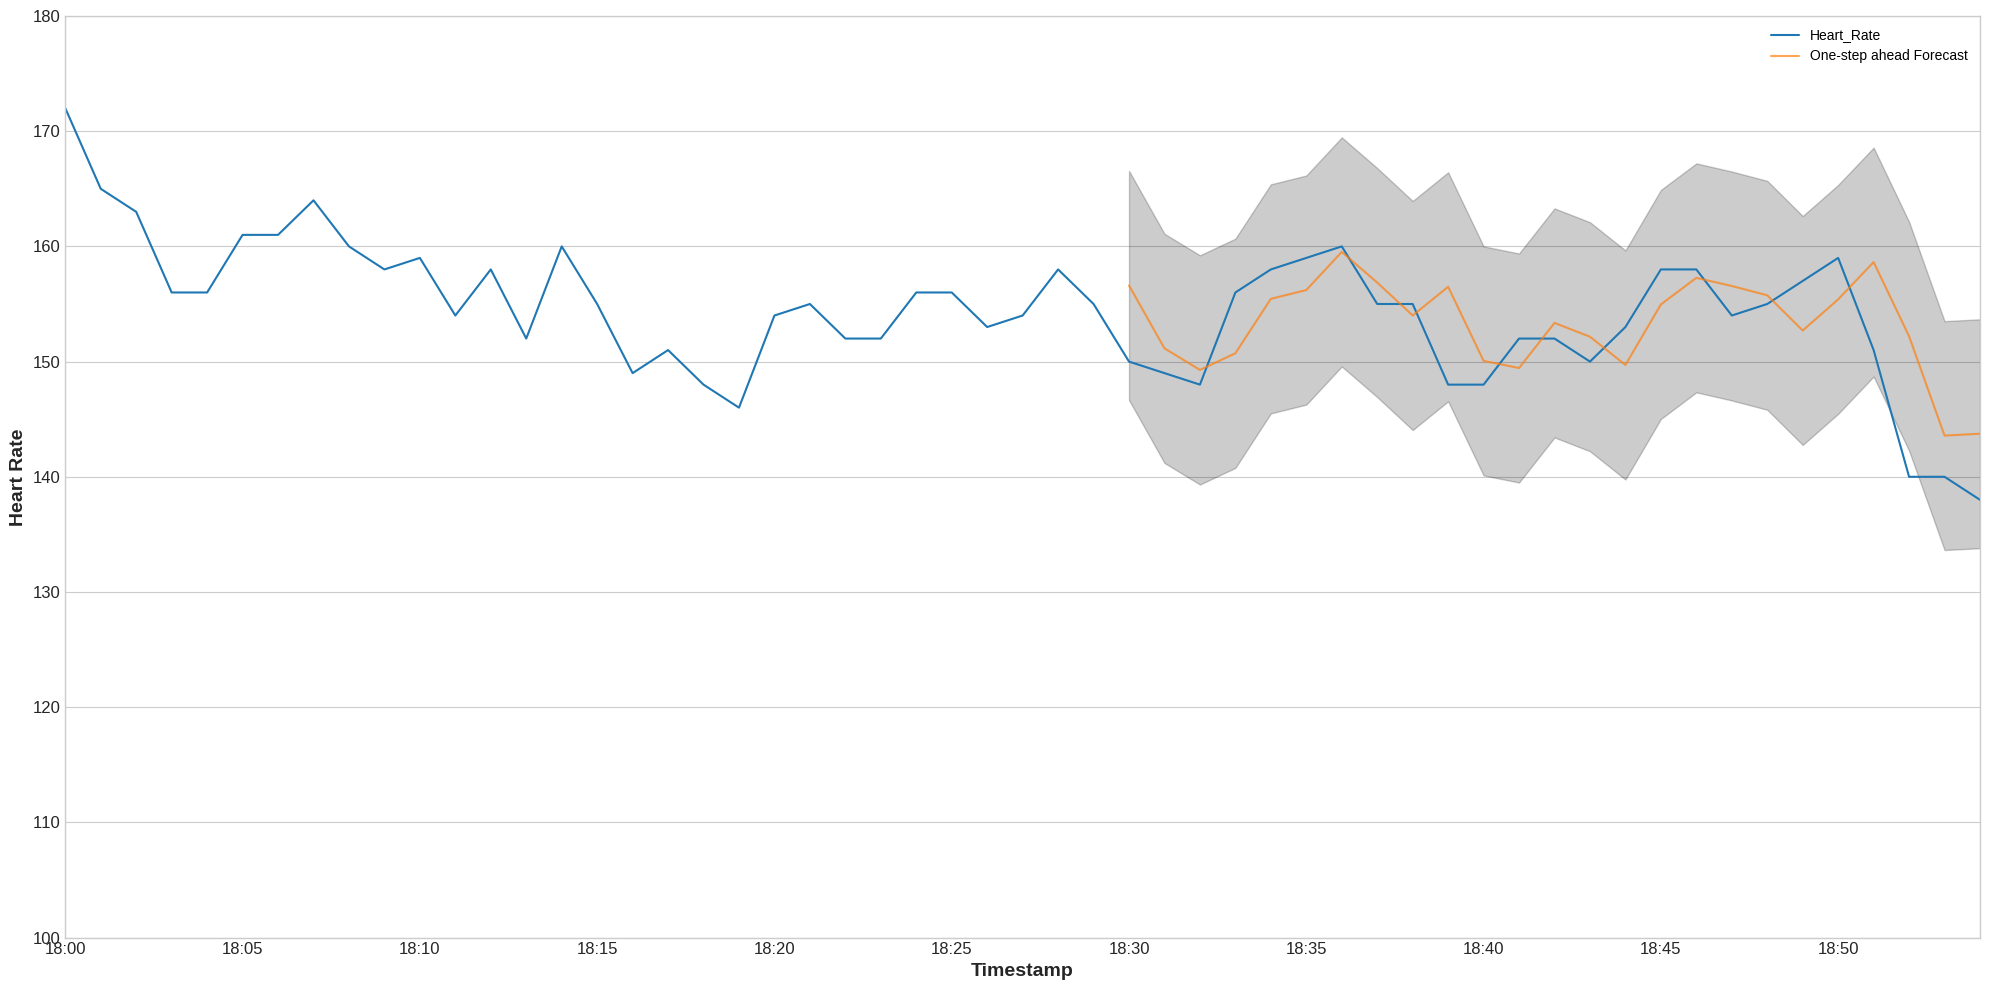

In [245]:
pred = results.get_prediction(start=pd.to_datetime('2015-08-17 18:30:00'), dynamic=False)
pred_ci = pred.conf_int()

ax = df['2015-08-17 18:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 10))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Heart Rate')
plt.legend()
plt.ylim(100,180)
plt.show()

In [246]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(226, 1)
(196, 1) (30, 1)


In [247]:
start=len(train)
end=len(train)+len(test)-1
pred=results.predict(start=start,end=end,typ='levels')
pred.index=df.index[start:end+1]
print(pred)

Timestamp
2015-08-17 18:25:00    153.242854
2015-08-17 18:26:00    154.595550
2015-08-17 18:27:00    154.757620
2015-08-17 18:28:00    154.052423
2015-08-17 18:29:00    157.391246
2015-08-17 18:30:00    156.607121
2015-08-17 18:31:00    151.149648
2015-08-17 18:32:00    149.277544
2015-08-17 18:33:00    150.722281
2015-08-17 18:34:00    155.446610
2015-08-17 18:35:00    156.210134
2015-08-17 18:36:00    159.519592
2015-08-17 18:37:00    156.860626
2015-08-17 18:38:00    153.999717
2015-08-17 18:39:00    156.492719
2015-08-17 18:40:00    150.061210
2015-08-17 18:41:00    149.443346
2015-08-17 18:42:00    153.355731
2015-08-17 18:43:00    152.158419
2015-08-17 18:44:00    149.707081
2015-08-17 18:45:00    154.960067
2015-08-17 18:46:00    157.269811
2015-08-17 18:47:00    156.562867
2015-08-17 18:48:00    155.754698
2015-08-17 18:49:00    152.700117
2015-08-17 18:50:00    155.403539
2015-08-17 18:51:00    158.637950
2015-08-17 18:52:00    152.196657
2015-08-17 18:53:00    143.576599
2015

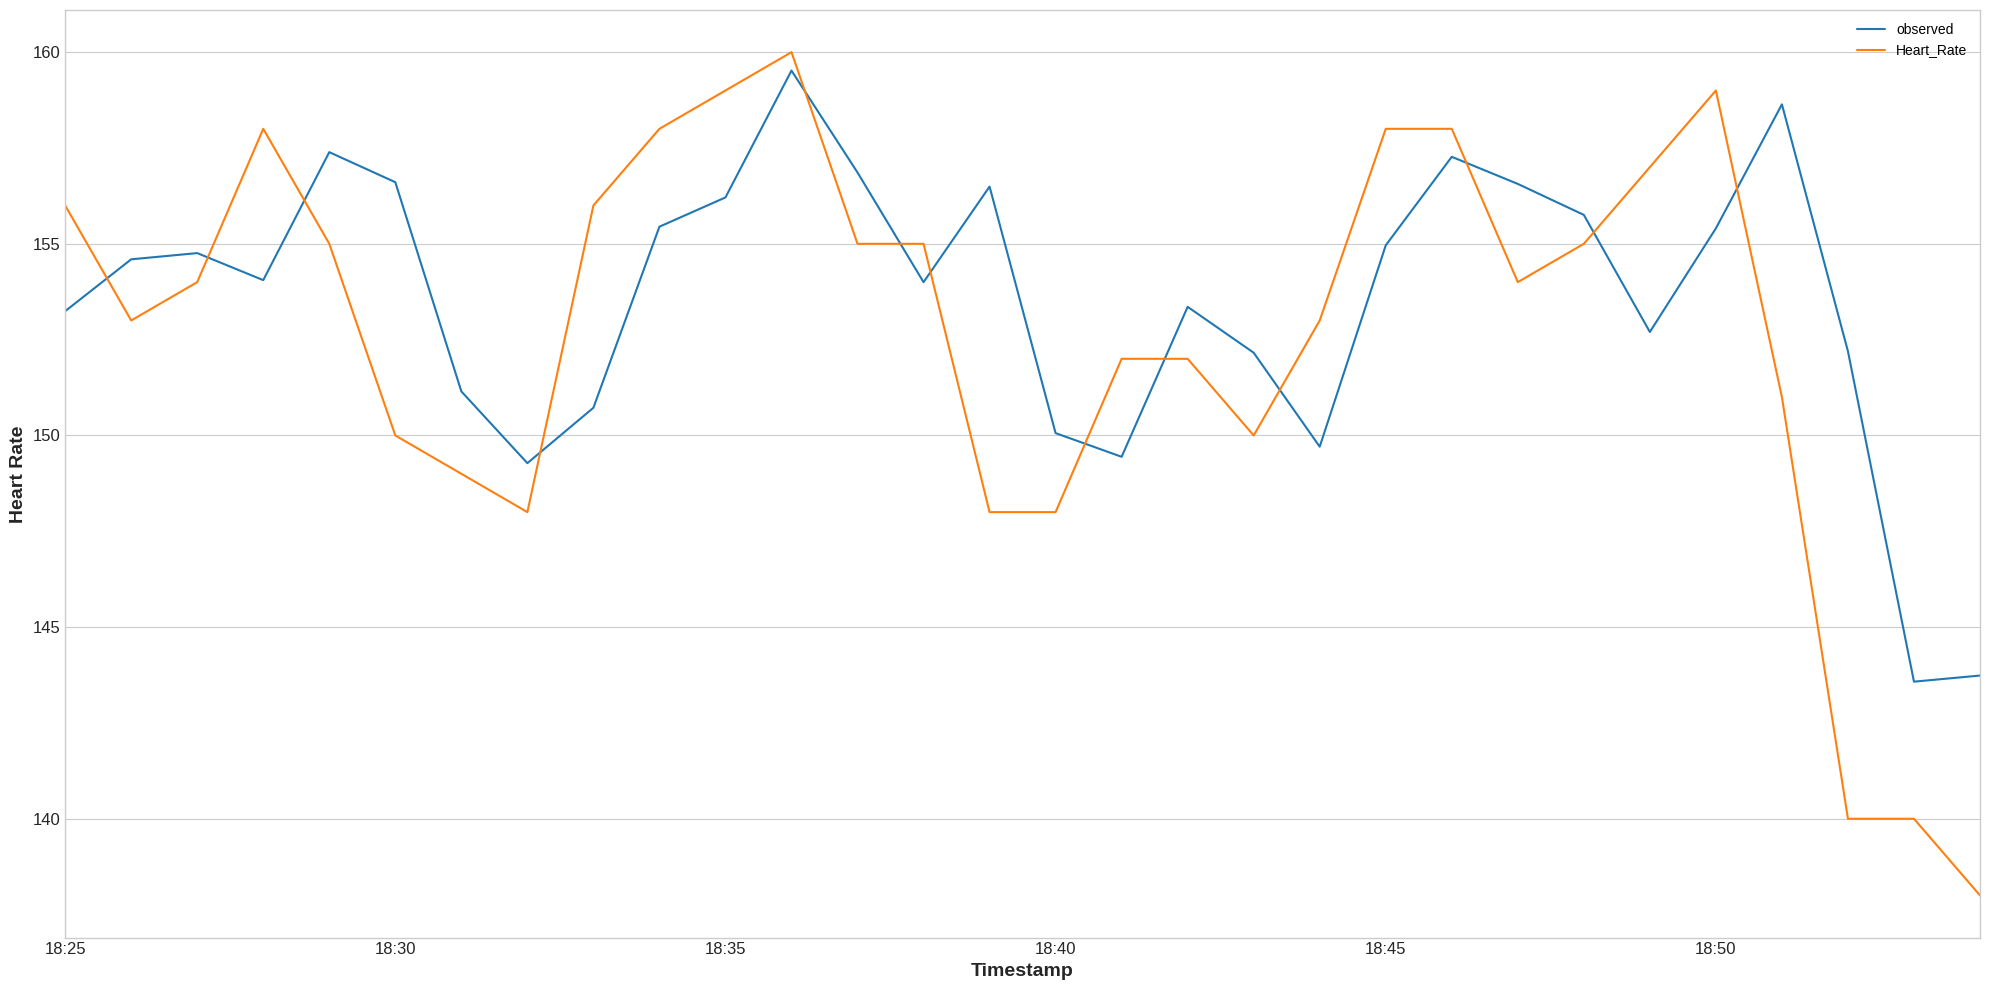

In [248]:
plt.figure(figsize=(20, 10))
pred.plot(legend=True,label='observed')
test['Heart_Rate'].plot(legend=True)
plt.xlabel('Timestamp')
plt.ylabel('Heart Rate')
plt.legend()

plt.show()

In [249]:
test['Heart_Rate'].mean()

152.63333333333333

In [250]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Heart_Rate']))
print(rmse)

4.203831688722875


In [251]:
mae = mean_absolute_error(pred,test['Heart_Rate'])
print(mae)

3.3165092344609604


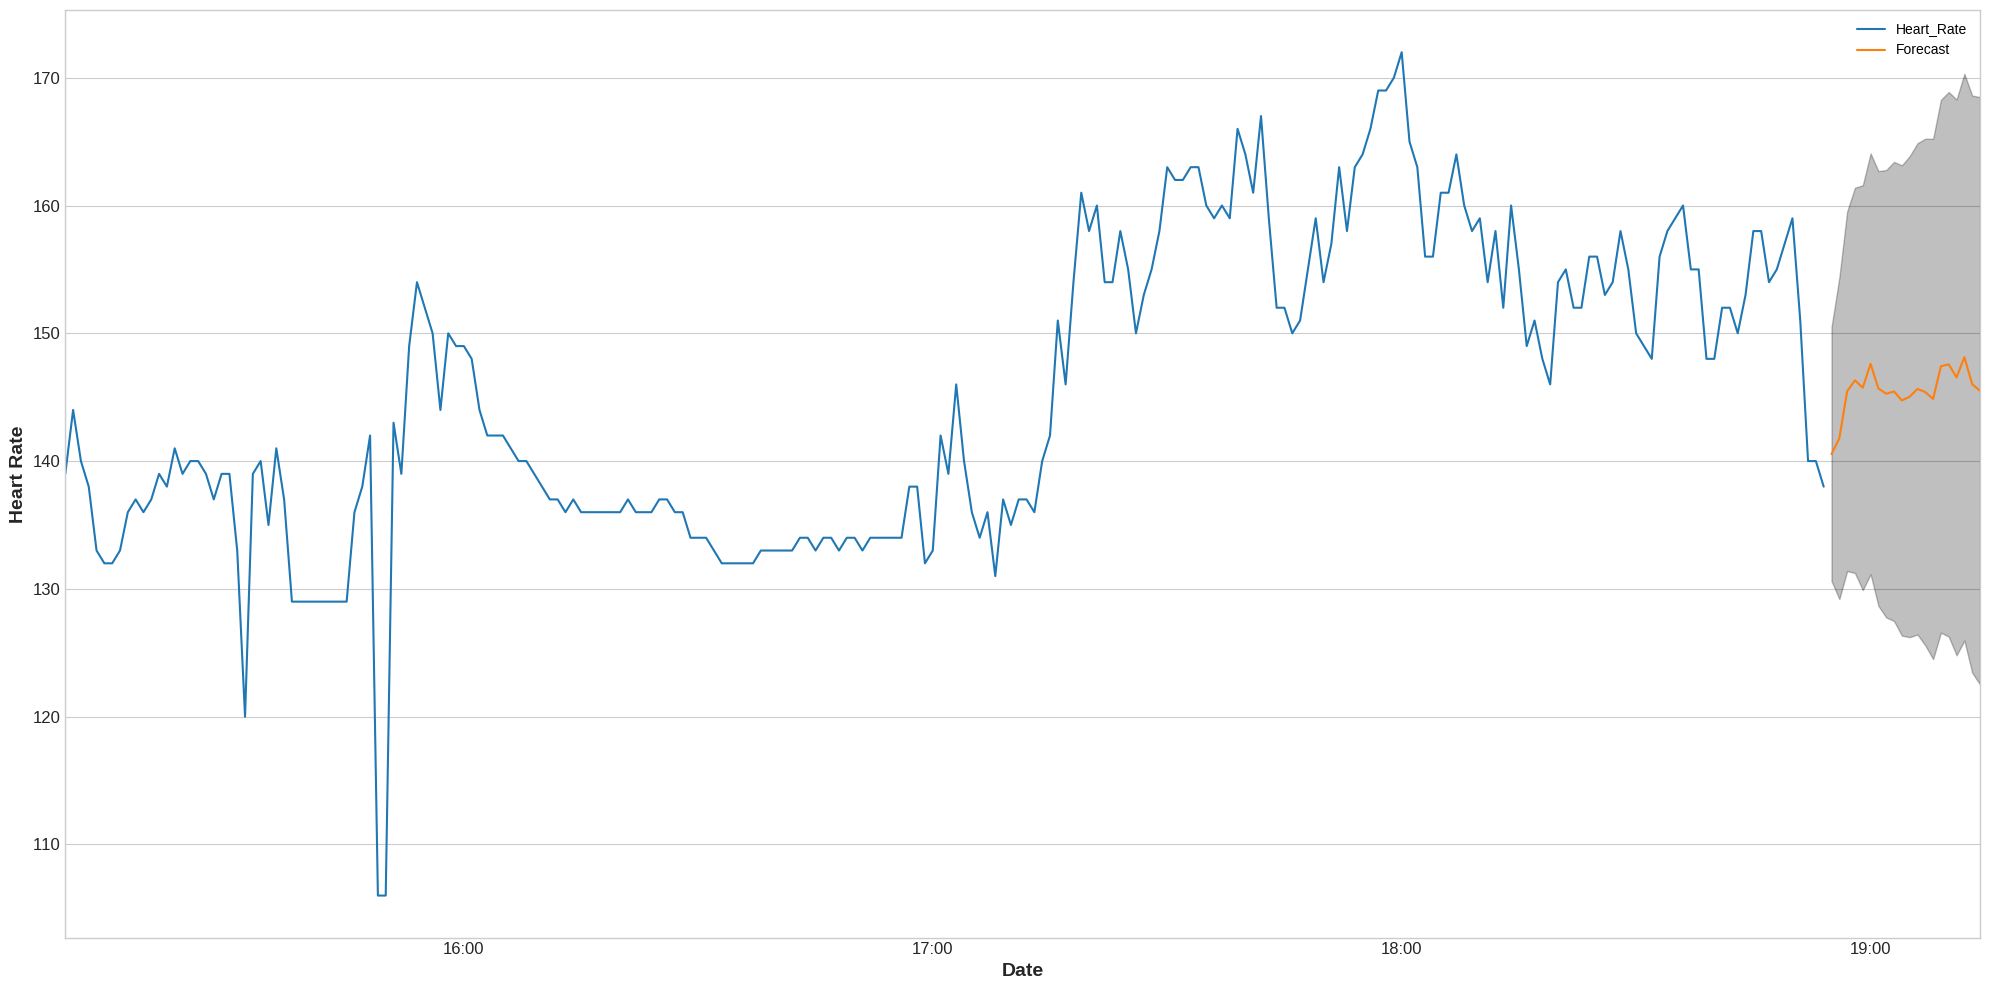

In [252]:
# Forecasting for the next 20 minutes
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Heart Rate')

plt.legend()
plt.show()

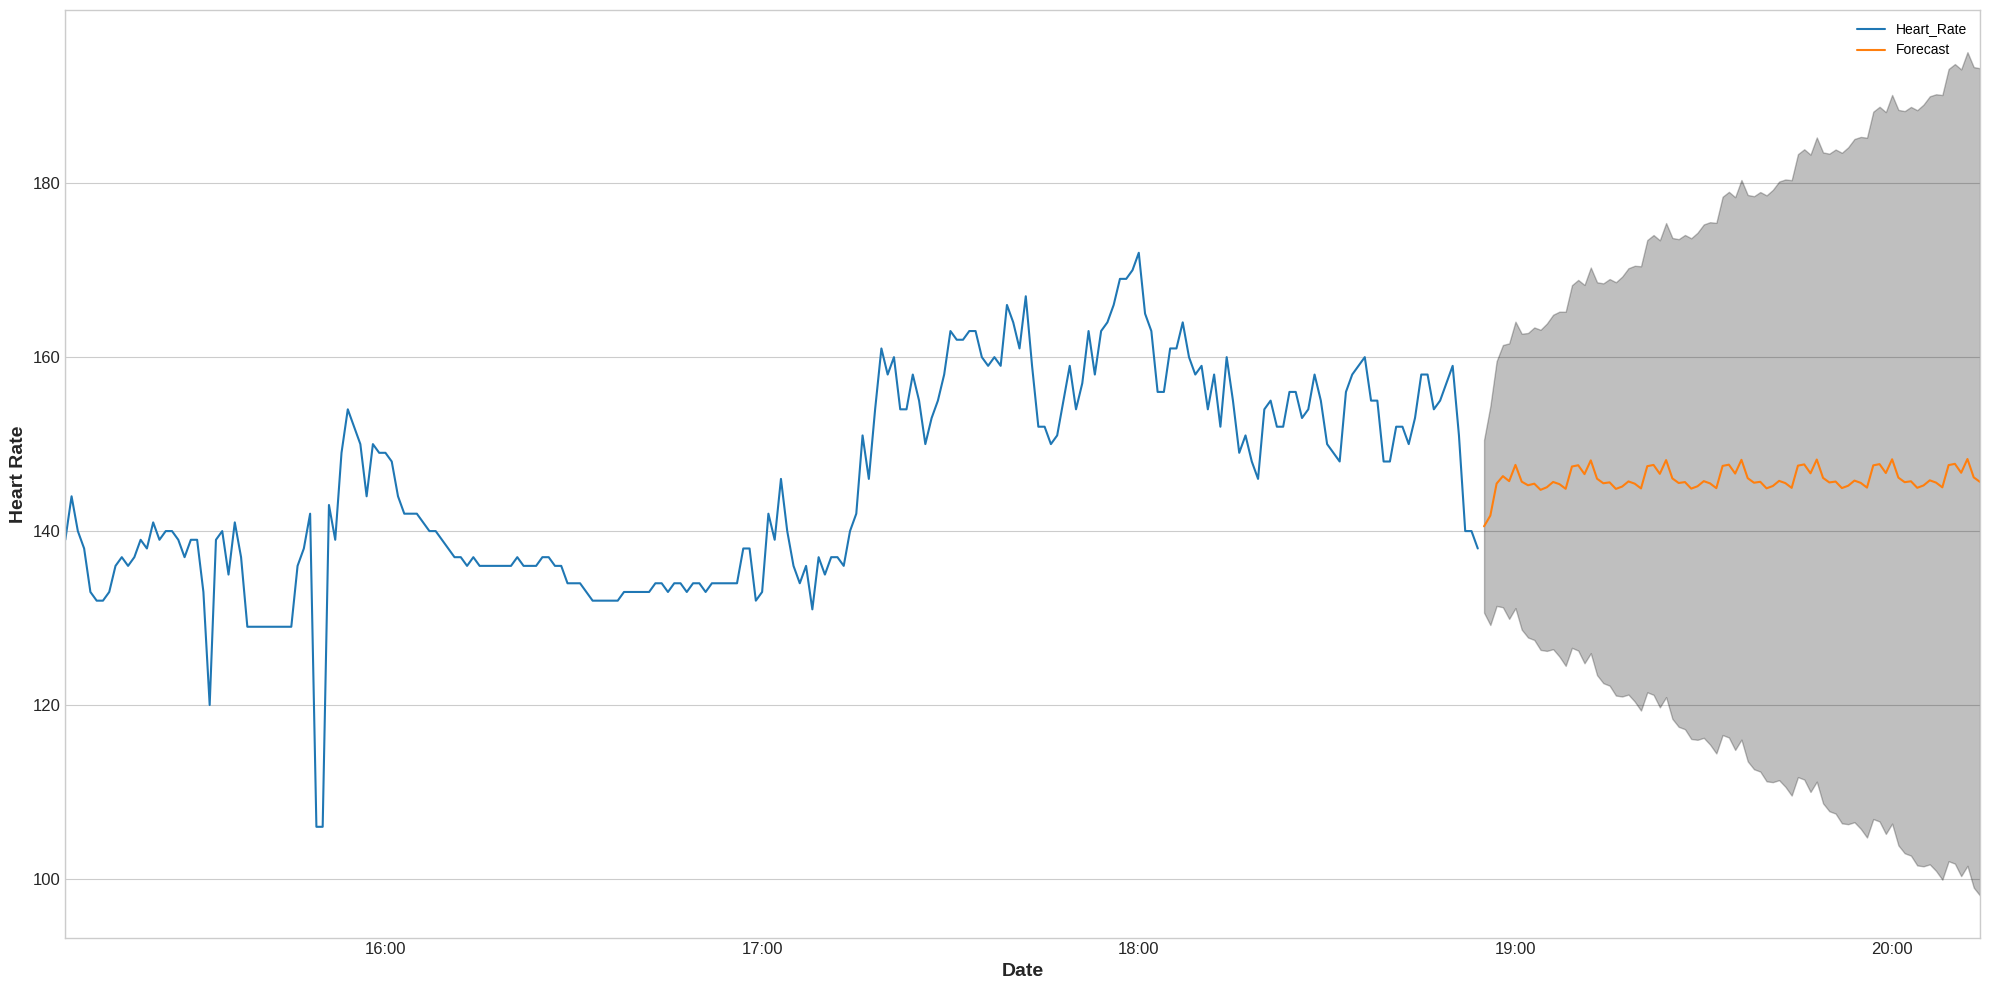

In [253]:
# Forecasting for the next hour
pred_uc2 = results.get_forecast(steps=80)
pred_ci2 = pred_uc2.conf_int()

ax = df.plot(label='observed', figsize=(20, 10))
pred_uc2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Heart Rate')

plt.legend()
plt.show()

In [254]:
forecasts1 = results.forecast(steps=20)
forecasts2 = results.forecast(steps=60)


In [255]:
forecasts1.to_csv('predictions.csv')
forecasts2.to_csv('predictions.csv')

# Prophet

In [256]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [257]:
import pandas as pd
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
from prophet import Prophet

In [258]:
import pandas as pd
input_file_name = '/content/data.csv'
df = pd.read_csv(input_file_name)

df.head()

,Unnamed: 0,Timestamp,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,0,2015-08-17 15:09:00,139.0,41,92,140
1,1,2015-08-17 15:10:00,144.0,40,92,140
2,2,2015-08-17 15:11:00,140.0,42,89,144
3,3,2015-08-17 15:12:00,138.0,45,93,141
4,4,2015-08-17 15:13:00,133.0,42,94,134


In [259]:
df.shape

(226, 6)

In [260]:
df=df[["Timestamp","Heart_Rate"]]
df.head()

,Timestamp,Heart_Rate
0,2015-08-17 15:09:00,139.0
1,2015-08-17 15:10:00,144.0
2,2015-08-17 15:11:00,140.0
3,2015-08-17 15:12:00,138.0
4,2015-08-17 15:13:00,133.0


In [261]:
df.columns = ['ds','y']

In [262]:
df['ds'] = pd.to_datetime(df['ds'])
df.tail()

,ds,y
221,2015-08-17 18:50:00,159.0
222,2015-08-17 18:51:00,151.0
223,2015-08-17 18:52:00,140.0
224,2015-08-17 18:53:00,140.0
225,2015-08-17 18:54:00,138.0


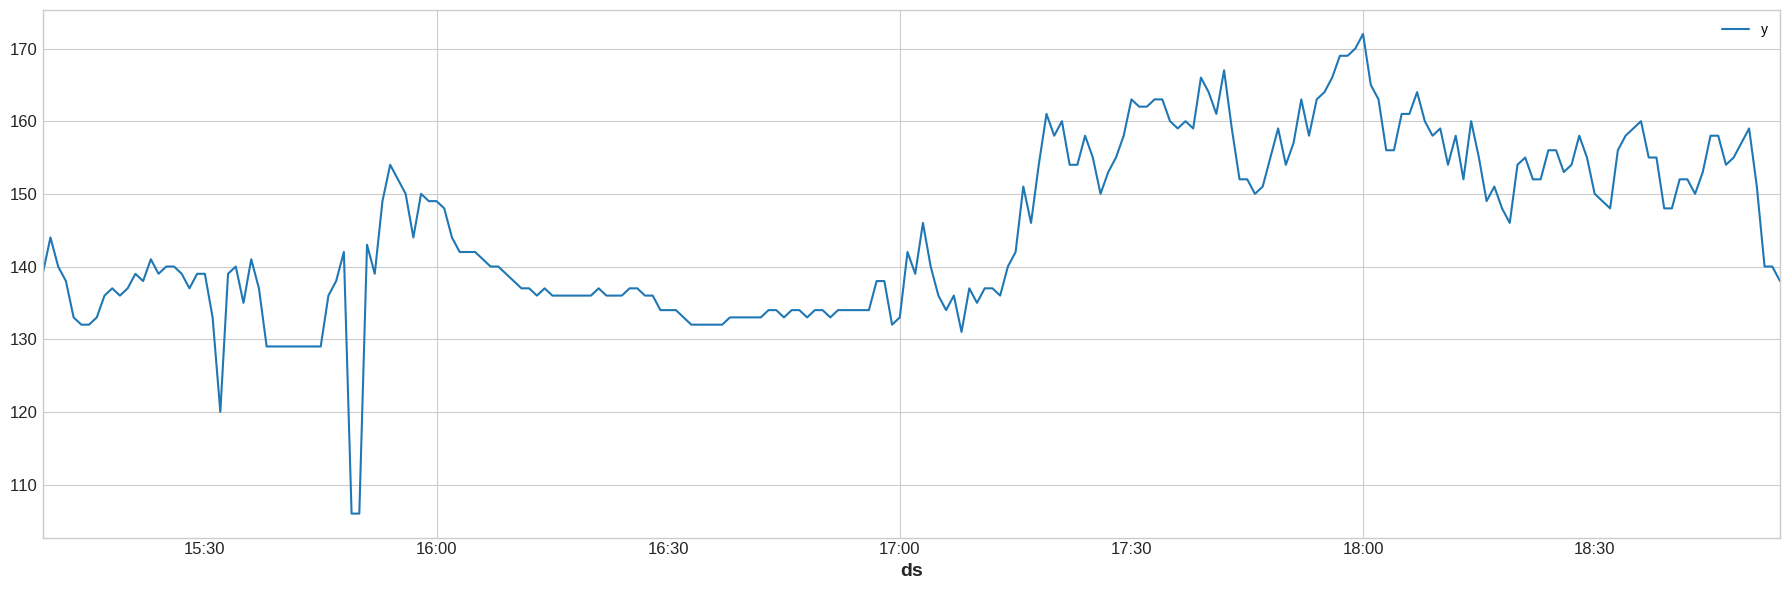

In [263]:
df.plot(x='ds',y='y',figsize=(18,6))

In [264]:
len(df)

226

In [265]:
df_model = Prophet(interval_width=0.95)
df_model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35ks2k64/srhgsecd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35ks2k64/ltklre31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53007', 'data', 'file=/tmp/tmp35ks2k64/srhgsecd.json', 'init=/tmp/tmp35ks2k64/ltklre31.json', 'output', 'file=/tmp/tmp35ks2k64/prophet_model0hg3rp_u/prophet_model-20221210055809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:58:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:58:09 - cmdstanpy - INFO - Chain 

In [266]:
df_forecast = df_model.make_future_dataframe(periods=50, freq='1min')
df_forecast = df_model.predict(df_forecast)

<Figure size 1800x600 with 0 Axes>

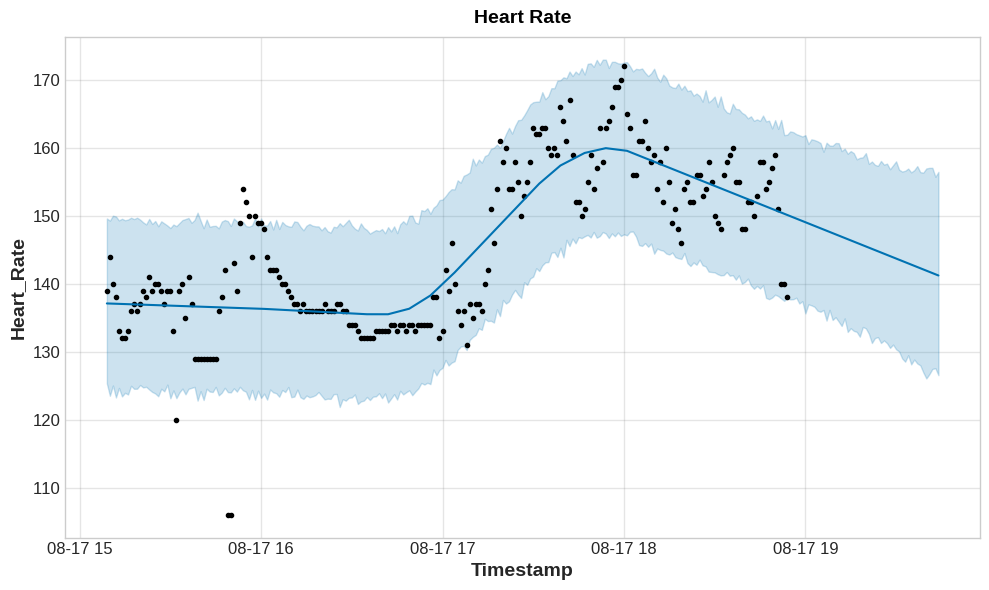

In [267]:
plt.figure(figsize=(18, 6))
df_model.plot(df_forecast, xlabel = 'Timestamp', ylabel = 'Heart_Rate')
plt.title('Heart Rate');

In [268]:
df_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
271,2015-08-17 19:40:00,141.942730,126.068571,156.984943,133.307848,149.155050,0.0,0.0,0.0,0.0,0.0,0.0,141.942730
272,2015-08-17 19:41:00,141.764558,126.698926,157.070377,132.910781,149.278833,0.0,0.0,0.0,0.0,0.0,0.0,141.764558
273,2015-08-17 19:42:00,141.586386,127.468849,157.076206,132.465887,149.387224,0.0,0.0,0.0,0.0,0.0,0.0,141.586386
274,2015-08-17 19:43:00,141.408215,127.578410,155.753375,132.018870,149.515162,0.0,0.0,0.0,0.0,0.0,0.0,141.408215
275,2015-08-17 19:44:00,141.230043,126.552461,156.486249,131.611272,149.392419,0.0,0.0,0.0,0.0,0.0,0.0,141.230043


In [269]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][226: 250]

,ds,yhat,yhat_lower,yhat_upper
226,2015-08-17 18:55:00,149.960456,137.704231,162.440422
227,2015-08-17 18:56:00,149.782284,137.735627,162.329428
228,2015-08-17 18:57:00,149.604112,137.958663,162.040190
229,2015-08-17 18:58:00,149.425941,137.103134,161.872626
230,2015-08-17 18:59:00,149.247769,137.448969,161.692782
231,2015-08-17 19:00:00,149.069597,135.642676,161.884801
232,2015-08-17 19:01:00,148.891425,136.975759,160.586466
233,2015-08-17 19:02:00,148.713254,136.838240,161.276706
234,2015-08-17 19:03:00,148.535082,136.625657,161.165094
235,2015-08-17 19:04:00,148.356910,136.055158,160.991323


In [270]:
predictions = df_forecast.iloc[226:250]['yhat']
print(predictions)

226    149.960456
227    149.782284
228    149.604112
229    149.425941
230    149.247769
231    149.069597
232    148.891425
233    148.713254
234    148.535082
235    148.356910
236    148.178739
237    148.000567
238    147.822395
239    147.644224
240    147.466052
241    147.287880
242    147.109709
243    146.931537
244    146.753365
245    146.575194
246    146.397022
247    146.218850
248    146.040679
249    145.862507
Name: yhat, dtype: float64


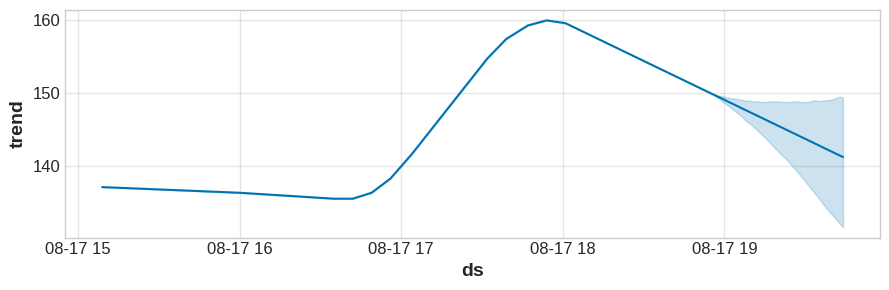

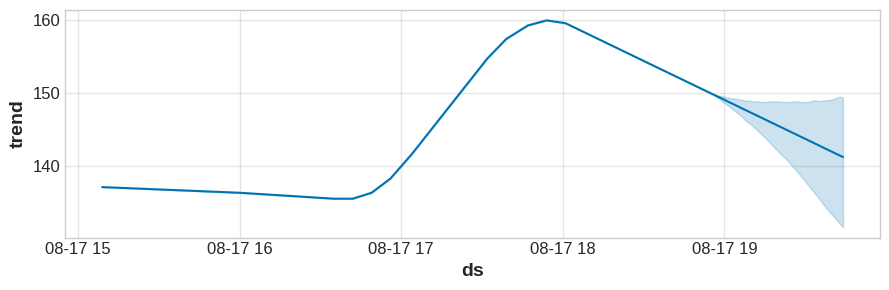

In [271]:
df_model.plot_components(df_forecast)

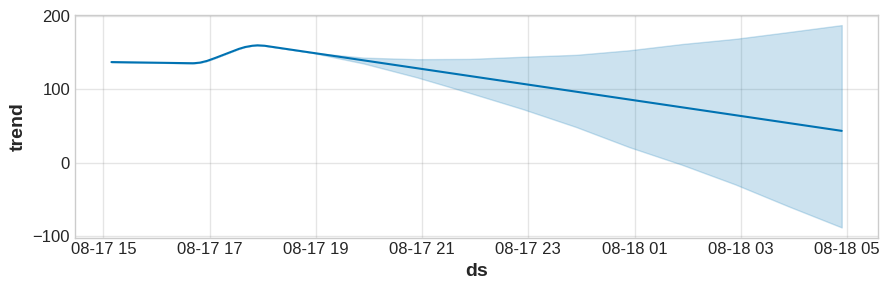

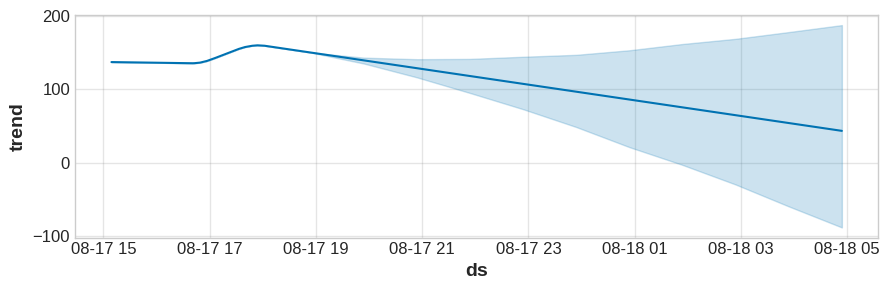

In [272]:
df_forecast2 = df_model.make_future_dataframe(periods=10, freq='1h')
df_forecast2 = df_model.predict(df_forecast2)
df_forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][226: 250]
predictions2 = df_forecast2.iloc[226: 250]['yhat']
df_model.plot_components(df_forecast2)

In [273]:
from statsmodels.tools.eval_measures import rmse

In [274]:
metric_df = df_forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [275]:
metric_df.head()

,ds,yhat,y
0,2015-08-17 15:09:00,137.115132,139.0
1,2015-08-17 15:10:00,137.100032,144.0
2,2015-08-17 15:11:00,137.084933,140.0
3,2015-08-17 15:12:00,137.069833,138.0
4,2015-08-17 15:13:00,137.054734,133.0


In [276]:
metric_df.dropna(inplace=True)

In [277]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

r2 = r2_score(metric_df.y, metric_df.yhat)
print(r2)

0.7107485179762647


In [278]:
mse = mean_squared_error(metric_df.y, metric_df.yhat)
print(mse)

40.107332096540745


In [279]:
mae = mean_absolute_error(metric_df.y, metric_df.yhat)
print(mae)

4.651972814211157


In [280]:
import numpy as np
rmse = np.sqrt(mse)
print(rmse)

6.333034983050444


# LSTM

In [281]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [283]:
from pandas._libs.tslibs.parsing import parse_datetime_string
from pandas.core.indexes.period import parse_time_string
from pandas._libs.tslibs.timedeltas import parse_timedelta_unit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


from math import sqrt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
df=pd.read_csv('data.csv', index_col='Timestamp', parse_dates=True)
df=pd.DataFrame(df[['Heart_Rate']])

In [284]:
df.head()

,Heart_Rate
Timestamp,
2015-08-17 15:09:00,139.0
2015-08-17 15:10:00,144.0
2015-08-17 15:11:00,140.0
2015-08-17 15:12:00,138.0
2015-08-17 15:13:00,133.0


In [285]:
df.columns= ['value']

In [286]:
df.tail()

,value
Timestamp,
2015-08-17 18:50:00,159.0
2015-08-17 18:51:00,151.0
2015-08-17 18:52:00,140.0
2015-08-17 18:53:00,140.0
2015-08-17 18:54:00,138.0


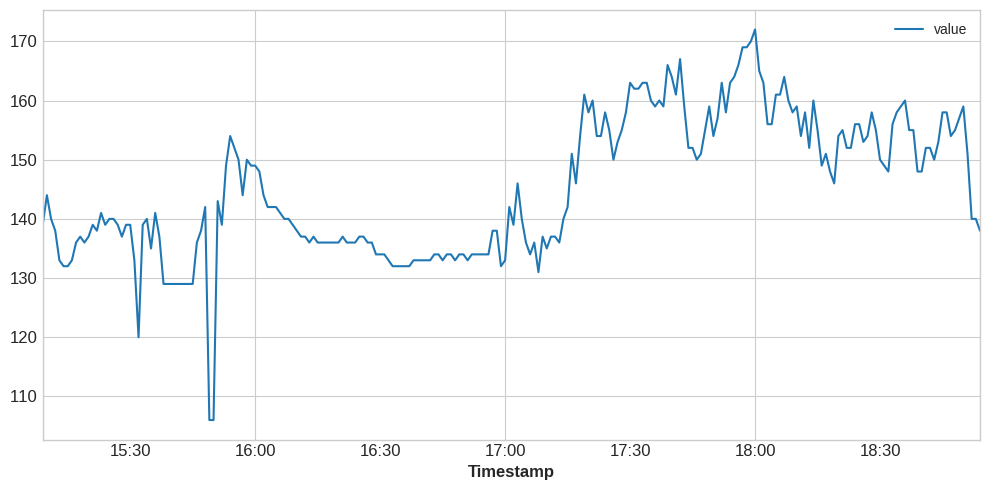

In [287]:
df.plot()

In [288]:
prediction_window=12

In [289]:
n_input=12
n_features=1

In [290]:
train = df.copy()

In [291]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

In [292]:

train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(196, 1) (30, 1)


In [293]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [294]:
x, y = sliding_windows(scaled_train, prediction_window)


In [295]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.5        0.57575758 0.51515152 0.48484848 0.40909091 0.39393939
 0.39393939 0.40909091 0.45454545 0.46969697 0.45454545 0.46969697]
Predict this value: 
 [0.5]


In [296]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

In [297]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [298]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out

In [299]:
EPOCHS = 200
LEARNING_RATE = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [300]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [301]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [302]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')


Epoch 0: Validation loss decreased (inf --> 0.322431).  Saving model ...
	 Train_Loss: 0.1980 Val_Loss: 0.3224  BEST VAL Loss: 0.3224

Epoch 1: Validation loss decreased (0.322431 --> 0.306144).  Saving model ...
	 Train_Loss: 0.1860 Val_Loss: 0.3061  BEST VAL Loss: 0.3061

Epoch 2: Validation loss decreased (0.306144 --> 0.290673).  Saving model ...
	 Train_Loss: 0.1749 Val_Loss: 0.2907  BEST VAL Loss: 0.2907

Epoch 3: Validation loss decreased (0.290673 --> 0.276224).  Saving model ...
	 Train_Loss: 0.1644 Val_Loss: 0.2762  BEST VAL Loss: 0.2762

Epoch 4: Validation loss decreased (0.276224 --> 0.261676).  Saving model ...
	 Train_Loss: 0.1549 Val_Loss: 0.2617  BEST VAL Loss: 0.2617

Epoch 5: Validation loss decreased (0.261676 --> 0.246026).  Saving model ...
	 Train_Loss: 0.1453 Val_Loss: 0.2460  BEST VAL Loss: 0.2460

Epoch 6: Validation loss decreased (0.246026 --> 0.229061).  Saving model ...
	 Train_Loss: 0.1353 Val_Loss: 0.2291  BEST VAL Loss: 0.2291

Epoch 7: Validation loss 

In [303]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [304]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [305]:
df_pred=train.iloc[-54:]
df_pred['prediction']=y_pred

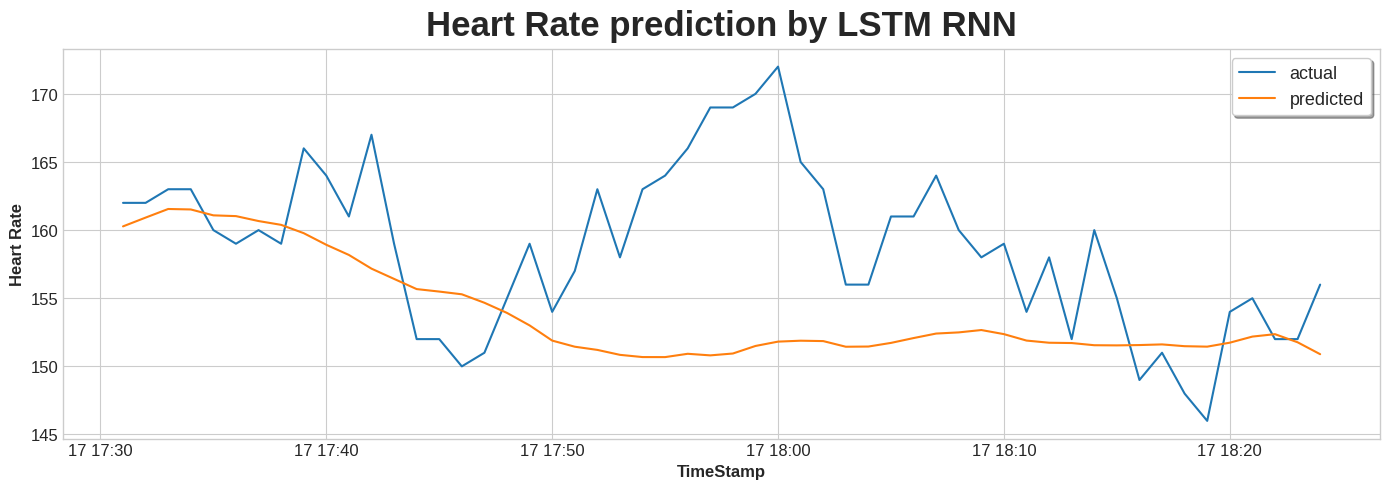

In [306]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["value"], label="actual")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted")
plt.title("Heart Rate prediction by LSTM RNN", fontsize=25)
plt.ylabel("Heart Rate")
plt.xlabel("TimeStamp")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [307]:
mape_lstm = mape(df_pred["value"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 3.76 %


In [308]:
mae_lstm = mean_absolute_error(df_pred["value"], df_pred["prediction"])
print(mae_lstm)

6.092023213704427


In [309]:
rmse_lstm = mean_squared_error(df_pred["value"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 8.01


In [310]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:])) # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(scaled_train[-n_input:])):
    #get the prediction value for the first batch
    current_pred = model(current_batch)
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [311]:

forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)
print(len(test_predictions))

12


In [312]:

date_offset=12
forecast_dates =  (train.index + pd.DateOffset(minutes=1))[-date_offset:]
                   #pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2015-08-17 18:14:00', '2015-08-17 18:15:00',
               '2015-08-17 18:16:00', '2015-08-17 18:17:00',
               '2015-08-17 18:18:00', '2015-08-17 18:19:00',
               '2015-08-17 18:20:00', '2015-08-17 18:21:00',
               '2015-08-17 18:22:00', '2015-08-17 18:23:00',
               '2015-08-17 18:24:00', '2015-08-17 18:25:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)

In [313]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals
df_forecast.head(20)

,prediction
date,
2015-08-17 18:14:00,149.796913
2015-08-17 18:15:00,149.399534
2015-08-17 18:16:00,148.920400
2015-08-17 18:17:00,148.337418
2015-08-17 18:18:00,147.833851
2015-08-17 18:19:00,147.507655
2015-08-17 18:20:00,147.210417
2015-08-17 18:21:00,146.932447
2015-08-17 18:22:00,146.689375


In [314]:
df_full=df_pred.append(df_forecast)
df_full.dropna(inplace=True)
print(df_full)

                     value  prediction
2015-08-17 17:31:00  162.0  160.273407
2015-08-17 17:32:00  162.0  160.918304
2015-08-17 17:33:00  163.0  161.550308
2015-08-17 17:34:00  163.0  161.515656
2015-08-17 17:35:00  160.0  161.083328
2015-08-17 17:36:00  159.0  161.027512
2015-08-17 17:37:00  160.0  160.665161
2015-08-17 17:38:00  159.0  160.385986
2015-08-17 17:39:00  166.0  159.775269
2015-08-17 17:40:00  164.0  158.923340
2015-08-17 17:41:00  161.0  158.177231
2015-08-17 17:42:00  167.0  157.172058
2015-08-17 17:43:00  159.0  156.419449
2015-08-17 17:44:00  152.0  155.671738
2015-08-17 17:45:00  152.0  155.489349
2015-08-17 17:46:00  150.0  155.289398
2015-08-17 17:47:00  151.0  154.668243
2015-08-17 17:48:00  155.0  153.922577
2015-08-17 17:49:00  159.0  153.006546
2015-08-17 17:50:00  154.0  151.891800
2015-08-17 17:51:00  157.0  151.442932
2015-08-17 17:52:00  163.0  151.208481
2015-08-17 17:53:00  158.0  150.845413
2015-08-17 17:54:00  163.0  150.682312
2015-08-17 17:55:00  164.

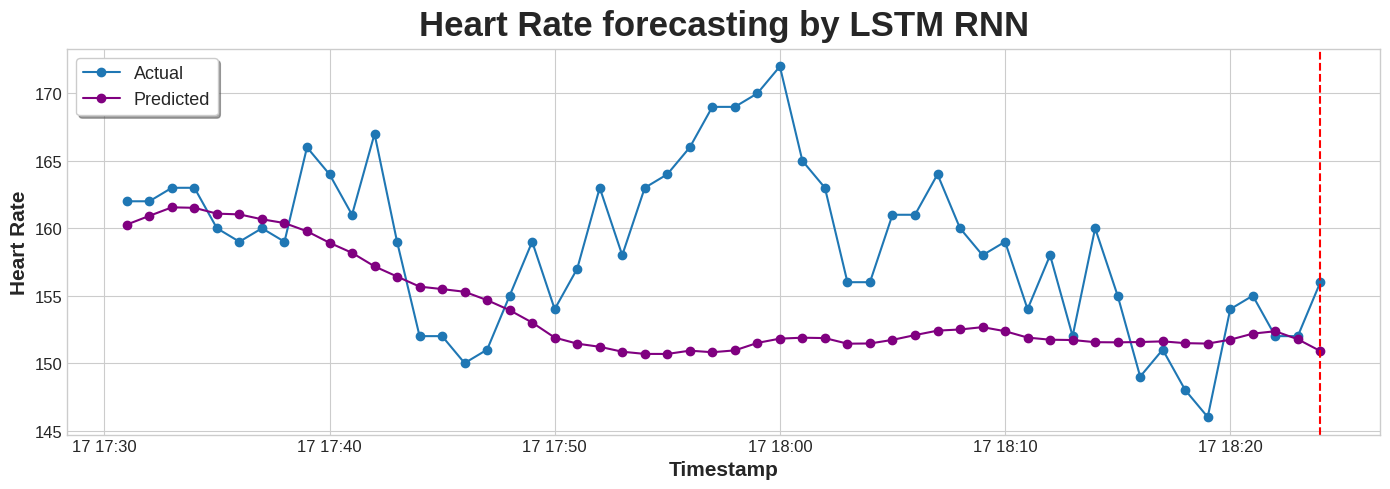

In [315]:
plt.figure(figsize=(14,5))
plt.plot(df_full.index,df_full["value"], label="Actual", marker="o")
plt.plot(df_full.index,df_full["prediction"], label="Predicted", marker="o", color="purple")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.title("Heart Rate forecasting by LSTM RNN", fontsize=25)
plt.ylabel('Heart Rate', fontsize=15)
plt.xlabel('Timestamp', fontsize=15)
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [316]:
prediction_window=24

In [317]:
n_input=24
n_features=1

In [318]:
train = df.copy()

In [319]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

In [320]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(226, 1)
(196, 1) (30, 1)


In [321]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [322]:
x, y = sliding_windows(scaled_train, prediction_window)

In [323]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.5        0.57575758 0.51515152 0.48484848 0.40909091 0.39393939
 0.39393939 0.40909091 0.45454545 0.46969697 0.45454545 0.46969697
 0.5        0.48484848 0.53030303 0.5        0.51515152 0.51515152
 0.5        0.46969697 0.5        0.5        0.40909091 0.21212121]
Predict this value: 
 [0.5]


In [324]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

In [325]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [326]:
EPOCHS = 200
LEARNING_RATE = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [328]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [329]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [330]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')


Epoch 0: Validation loss decreased (inf --> 0.399477).  Saving model ...
	 Train_Loss: 0.1790 Val_Loss: 0.3995  BEST VAL Loss: 0.3995

Epoch 1: Validation loss decreased (0.399477 --> 0.377023).  Saving model ...
	 Train_Loss: 0.1659 Val_Loss: 0.3770  BEST VAL Loss: 0.3770

Epoch 2: Validation loss decreased (0.377023 --> 0.353965).  Saving model ...
	 Train_Loss: 0.1529 Val_Loss: 0.3540  BEST VAL Loss: 0.3540

Epoch 3: Validation loss decreased (0.353965 --> 0.330757).  Saving model ...
	 Train_Loss: 0.1402 Val_Loss: 0.3308  BEST VAL Loss: 0.3308

Epoch 4: Validation loss decreased (0.330757 --> 0.310772).  Saving model ...
	 Train_Loss: 0.1276 Val_Loss: 0.3108  BEST VAL Loss: 0.3108

Epoch 5: Validation loss decreased (0.310772 --> 0.293089).  Saving model ...
	 Train_Loss: 0.1160 Val_Loss: 0.2931  BEST VAL Loss: 0.2931

Epoch 6: Validation loss decreased (0.293089 --> 0.275307).  Saving model ...
	 Train_Loss: 0.1063 Val_Loss: 0.2753  BEST VAL Loss: 0.2753

Epoch 7: Validation loss 

In [331]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [332]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [333]:
df_pred=train.iloc[-78:]
df_pred['prediction']=y_pred

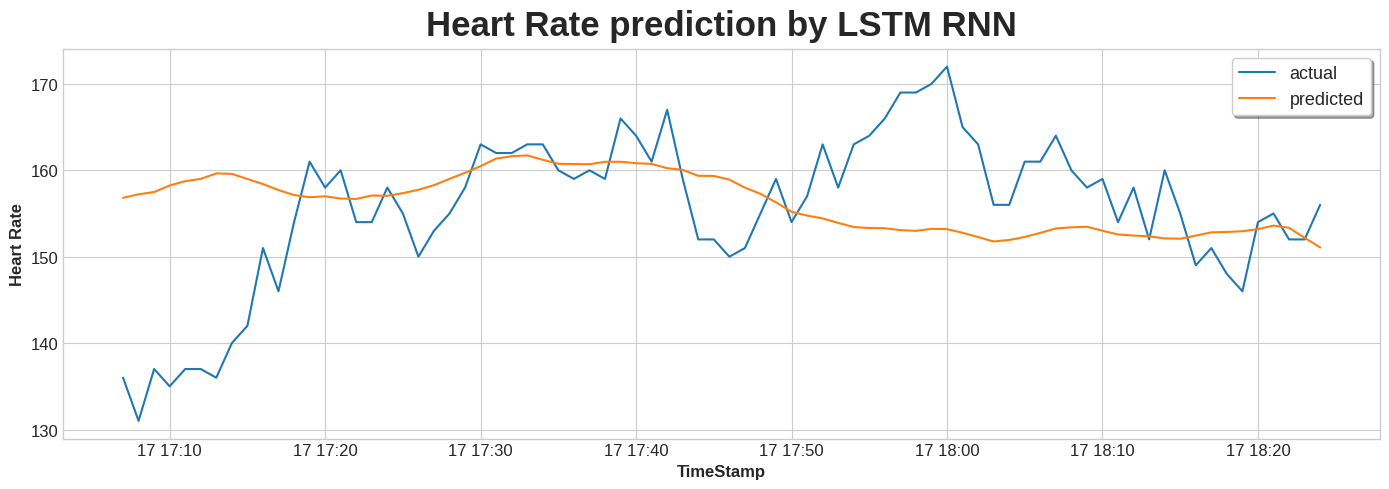

In [334]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["value"], label="actual")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted")
plt.title("Heart Rate prediction by LSTM RNN", fontsize=25)
plt.ylabel("Heart Rate")
plt.xlabel("TimeStamp")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [335]:
mape_lstm = mape(df_pred["value"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 4.71 %


In [336]:
mae_lstm = mean_absolute_error(df_pred["value"], df_pred["prediction"])
print(mae_lstm)

7.094427255483774


In [337]:
rmse_lstm = mean_squared_error(df_pred["value"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 9.78
